# Intent Classifier Optimization
This notebook involves optimizing intent and confirmation classifiers for mobile phone use to identify user agreement or disagreement efficiently. Initially, a dataset was acquired since call recordings from the contact center were unavailable. A list of intents was created, and utterances matching these intents were collected from five individuals or synthesized using text-to-speech technology. These recordings were transcribed, manually annotated for intent, and further annotated using a new LLM. Additional sample texts were generated to balance the dataset, which was then split into training and test sets.

A baseline model was fine-tuned on this data using a Hugging Face model, and evaluated using predefined metrics. For algorithmic data augmentation, round-trip translation in multiple languages and various distortions (e.g., random character insertions, word swaps) were applied to extend the training data, and the impact on model performance was assessed. The best-performing data-augmentation approach was used to train an optimized model.

To reduce model size, a small pretrained model was fine-tuned to match the performance of the best model from the previous step. The effects of model pruning and quantization on accuracy, size, and speed were evaluated. Additionally, a simple model (e.g., logistic regression with TFIDF) was trained for comparison. Finally, the most suitable model for the mobile app was recommended based on performance metrics, balancing accuracy, size, and inference speed.

In [1]:
intents = ['Sales','Support','Complaints','Account Management','Billing and Payments']
intents

['Sales',
 'Support',
 'Complaints',
 'Account Management',
 'Billing and Payments']

In this step, we will be utilizing the pygame package for playing the audio and pydub for converting the file format to wav.

In [2]:
#installed pygame
!pip install pygame

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#installed pydub
!pip install pydub

Defaulting to user installation because normal site-packages is not writeable


In [1]:
#imported necessary packages
from pydub import AudioSegment
import pygame

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
#defined function that converts the audio recordings in aac file to wav file formats

def convert_aac_to_wav(input_file, output_file):
    #loads the AAC audio file
    audio = AudioSegment.from_file(input_file, format="aac")
    
    #exports the audio into WAV format
    audio.export(output_file, format="wav")

In [6]:
#called function to convert aac audio recordings to wav file formats

input_file = 'billingpayments_person.aac'
output_file = 'billingpayments_converted.wav'
convert_aac_to_wav(input_file, output_file)

In [9]:
#called function to convert aac audio recordings to wav file formats

input_file = 'complaints_person.aac'
output_file = 'complaints_converted.wav'
convert_aac_to_wav(input_file, output_file)

In [7]:
#defined function that converts the audio recordings in m4a file to wav file formats

def convert_m4a_to_wav(input_file, output_file):
    #loads the mp4 audio file
    audio = AudioSegment.from_file(input_file, format="m4a")
    
    #exports the audio into WAV format
    audio.export(output_file, format="wav")

In [8]:
#called function to convert m4a audio recordings to wav file formats
input_file = 'sales_person.m4a'
output_file = 'sales_converted.wav'
convert_m4a_to_wav(input_file, output_file)

In [10]:
#called function to convert m4a audio recordings to wav file formats
input_file = 'support_person.m4a'
output_file = 'support_converted.wav'
convert_m4a_to_wav(input_file, output_file)

In [11]:
#called function to convert m4a audio recordings to wav file formats
input_file = 'account_person.m4a'
output_file = 'account_converted.wav'
convert_m4a_to_wav(input_file, output_file)

In [12]:
#installed transformers
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#imported necessary packages
from transformers import pipeline

In [14]:
#Using pipeline, created a transcriber that when called, converts an audio file and transcribes it into text
transcriber = pipeline(task="automatic-speech-recognition", model="openai/whisper-small")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
#imported logging so we can log the transcript into a text file
import logging

In [16]:
#Configures logging to write logs to a file named transcript.log
logging.basicConfig(filename='transcript.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#defined a function that would utilize the transcriber
#in case the transcriber fails, the user will be asked to manually type the script
def transcribe(input_file):
    print("Transcribing. Please wait...")
    try:
        transcript = transcriber(input_file)#calls the transcriber
        logging.info("Transcript: %s", transcript)  #Logs the transcript
        print("Transcript:", transcript)  #Prints the transcript
    except Exception as e:#should transcriber fail, the messages below will be displayed and the user will be prompted to enter transcript manually
        logging.error("Error occurred: %s", e)  # Log the error
        print("Error occurred:", e)  # Print the error message
        
    return transcript


In [17]:
#transcribed the sales wav file

#assigned file path of the recording used earlier to input_file variable
input_file = "sales_converted.wav"

#called transcribe function
transcribe(input_file)

Transcribing. Please wait...


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Transcript: {'text': " I'm interested in getting a phone plan. I'd like to buy a new iPhone. What are my options for Samsung Galaxy phone accessories? Do you offer a discount for students? How much does your para-bank cost?"}


{'text': " I'm interested in getting a phone plan. I'd like to buy a new iPhone. What are my options for Samsung Galaxy phone accessories? Do you offer a discount for students? How much does your para-bank cost?"}

In [18]:
#transcribed the support wav file

#assigned file path of the recording used earlier to input_file variable
input_file = "support_converted.wav"

#called transcribe function
transcribe(input_file)

Transcribing. Please wait...
Transcript: {'text': " My iPhone isn't working properly. I'm experiencing an issue with my mobile data. I'm having trouble with sending messages to my friends. I can't receive calls. There's an error message saying failed to connect when I played mobile latency."}


{'text': " My iPhone isn't working properly. I'm experiencing an issue with my mobile data. I'm having trouble with sending messages to my friends. I can't receive calls. There's an error message saying failed to connect when I played mobile latency."}

In [19]:
#transcribed the complaints wav file

#assigned file path of the recording used earlier to input_file variable
input_file = "complaints_converted.wav"

#called transcribe function
transcribe(input_file)

Transcribing. Please wait...
Transcript: {'text': " I'm dissatisfied with the technician who helped me yesterday. I'm unhappy with your service. I actually have a problem with the way you handled my request. This is unacceptable. I would like to speak with your supervisor. Fuck you! I hate you for treating me like shit!"}


{'text': " I'm dissatisfied with the technician who helped me yesterday. I'm unhappy with your service. I actually have a problem with the way you handled my request. This is unacceptable. I would like to speak with your supervisor. Fuck you! I hate you for treating me like shit!"}

In [21]:
#transcribed the accounts management wav file

#assigned file path of the recording used earlier to input_file variable
input_file = "account_converted.wav"

#called transcribe function
transcribe(input_file)

Transcribing. Please wait...
Transcript: {'text': " I'm having trouble logging in. I need help setting up my account. I forgot my username and password. I want to update my home address. Can you help me change my email address?"}


{'text': " I'm having trouble logging in. I need help setting up my account. I forgot my username and password. I want to update my home address. Can you help me change my email address?"}

In [22]:
#transcribed the billing and payments wav file

#assigned file path of the recording used earlier to input_file variable
input_file = "billingpayments_converted.wav"

#called transcribe function
transcribe(input_file)

Transcribing. Please wait...
Transcript: {'text': " Hi, I would like to dispute a charge made on my account. I haven't received my bill for the month of April. There is something wrong with my invoice statement. How much do I have to pay monthly for my plan? I forgot. I would like to pay monthly instead of yearly. Can you do that?"}


{'text': " Hi, I would like to dispute a charge made on my account. I haven't received my bill for the month of April. There is something wrong with my invoice statement. How much do I have to pay monthly for my plan? I forgot. I would like to pay monthly instead of yearly. Can you do that?"}

#### Manually annotated the intent of a few of them.

For this part, annotation was done in excel. In the following codes, we will be reading the file and converting it into a dataframe. Lastly, we will be displaying the first few contents of the said excel file.

In [1]:
#imported pandas for reading the excel file
import pandas as pd

#set path of the file to the excel_file variable
excel_file = 'manual_annotations.xlsx'

#Read the Excel file into a DataFrame
df = pd.read_excel(excel_file)

#Displayed the first few rows of the DataFrame
print(df.head())


   Label                                               Text
0  Sales         " I'm interested in getting a phone plan."
1    NaN                   "I'd like to buy a new iPhone. "
2    NaN  "What are my options for Samsung Galaxy phone ...
3  Sales            "Do you offer a discount for students?"
4    NaN               "How much does your para-bank cost?"


In [2]:
#checked that the dataframe consists of 25 rows (25 utterances)
print(df.shape)

(25, 2)


In [3]:
#checked the last few rows
print(df.tail())

                   Label                                               Text
20  Billing_and_Payments  " Hi, I would like to dispute a charge made on...
21  Billing_and_Payments  "I haven't received my bill for the month of A...
22                   NaN  "There is something wrong with my invoice stat...
23                   NaN  "How much do I have to pay monthly for my plan...
24                   NaN  "I would like to pay monthly instead of yearly...


#### Used an LLM to annotate the rest of them

Llama 2 70b model was prompted using a few-shot technique and identified the following intents for the 15/25 unlabelled statements.

"I'd like to buy a new iPhone." - Sales

"What are my options for Samsung Galaxy phone accessories?" - Sales

"How much does your para-bank cost?" - Sales

"My iPhone isn't working properly." - Support

"I'm having trouble with sending messages to my friends." - Support

"I can't receive calls." - Support

"I'm dissatisfied with the technician who helped me yesterday." - Complaints

"I actually have a problem with the way you handled my request." - Complaints

"Fuck you! I hate you for treating me like shit!" - Complaints

"I need help setting up my account." - Support

"I forgot my username and password." - Support

"Can you help me change my email address?" - Support

"There is something wrong with my invoice statement." - Billing and Payments

"How much do I have to pay monthly for my plan? I forgot." - Billing and Payments

"I would like to pay monthly instead of yearly. Can you do that?" - Billing and Payments

Based on the results above, it seems that Llama was able to identify the intents correctly except for all of the supposedly Account Management intent statements.

Now, we will update our dataframe with the intents provided by the Llama model.

In [4]:
#Firstly, we created a dictionary for the LLM's response

intent_dict = {
"I'd like to buy a new iPhone. " : 'Sales',

"What are my options for Samsung Galaxy phone accessories?": 'Sales',

" How much does your para-bank cost?" : 'Sales',

" My iPhone isn't working properly." : 'Support',

"I'm having trouble with sending messages to my friends." : 'Support',

" I can't receive calls. " : 'Support',

" I'm dissatisfied with the technician who helped me yesterday." : 'Complaints',

" I actually have a problem with the way you handled my request. " : 'Complaints',

"Fuck you! I hate you for treating me like shit!" : 'Complaints',

"I need help setting up my account. " : 'Support',

"I forgot my username and password." : 'Support',

"Can you help me change my email address?" : 'Support',

"There is something wrong with my invoice statement. " : 'Billing_and_Payments',

"How much do I have to pay monthly for my plan? I forgot. " : 'Billing_and_Payments',

"I would like to pay monthly instead of yearly. Can you do that?" : 'Billing_and_Payments'
}

intent_dict

{"I'd like to buy a new iPhone. ": 'Sales',
 'What are my options for Samsung Galaxy phone accessories?': 'Sales',
 ' How much does your para-bank cost?': 'Sales',
 " My iPhone isn't working properly.": 'Support',
 "I'm having trouble with sending messages to my friends.": 'Support',
 " I can't receive calls. ": 'Support',
 " I'm dissatisfied with the technician who helped me yesterday.": 'Complaints',
 ' I actually have a problem with the way you handled my request. ': 'Complaints',
 'Fuck you! I hate you for treating me like shit!': 'Complaints',
 'I need help setting up my account. ': 'Support',
 'I forgot my username and password.': 'Support',
 'Can you help me change my email address?': 'Support',
 'There is something wrong with my invoice statement. ': 'Billing_and_Payments',
 'How much do I have to pay monthly for my plan? I forgot. ': 'Billing_and_Payments',
 'I would like to pay monthly instead of yearly. Can you do that?': 'Billing_and_Payments'}

In [5]:
#Created a list of texts that have no labels
unlabeled_texts = df[df['Label'].isna()]['Text'].tolist()

#Displayed the list of unlabeled texts
print(unlabeled_texts)

['"I\'d like to buy a new iPhone. "', '"What are my options for Samsung Galaxy phone accessories?"', ' "How much does your para-bank cost?"', '" My iPhone isn\'t working properly."', '"I\'m having trouble with sending messages to my friends."', '" I can\'t receive calls." ', '" I\'m dissatisfied with the technician who helped me yesterday."', ' "I actually have a problem with the way you handled my request." ', '"Fuck you! I hate you for treating me like shit!"', '"I need help setting up my account." ', '"I forgot my username and password."', '"Can you help me change my email address?"', '"There is something wrong with my invoice statement." ', '"How much do I have to pay monthly for my plan? I forgot." ', '"I would like to pay monthly instead of yearly. Can you do that?"']


In [6]:
#Iterated through each row in the DataFrame
for index, row in df.iterrows():
    text = row['Text']
    for unlabeled in unlabeled_texts:
        if text == unlabeled:
            #we removed the quotation marks because when we do intent_dict[text] by default, the step adds quotation marks already so there will be a duplicate of quotation marks
            stripped_text = text.replace('"', '')
            #Updated the label in the DataFrame using .loc
            df.loc[index, 'Label'] = intent_dict[stripped_text]

In [7]:
#Verified that the labels have been rightfully updated
df

,Label,Text
0,Sales,""" I'm interested in getting a phone plan."""
1,Sales,"""I'd like to buy a new iPhone. """
2,Sales,"""What are my options for Samsung Galaxy phone ..."
3,Sales,"""Do you offer a discount for students?"""
4,Sales,"""How much does your para-bank cost?"""
5,Support,""" My iPhone isn't working properly."""
6,Support,"""I'm experiencing an issue with my mobile data."""
7,Support,"""I'm having trouble with sending messages to m..."
8,Support,""" I can't receive calls."""
9,Support,"""There's an error message saying failed to con..."


#### Got the LLM to generate another 25 sample texts; and balanced out the intents.

In the succeeding steps, we will attempt to create a balanced dataset of 50 sample texts. First, we count the occurences of each label to help us identify how the labels should be distributed.

In [8]:
#Counted the occurrences of each label
label_counts = df['Label'].value_counts()

label_counts

Label
Support                 8
Sales                   5
Complaints              5
Billing_and_Payments    5
Account_Management      2
Name: count, dtype: int64

Looking at the counts summary above, and considering that we have 5 intents and that we will have 50 texts all in all; then it is ideal for each intent to have 10 texts each for a truly balanced dataset. In order for us to do that, the 25 additional texts should be distributed in the following manner:

-Support: 2
-Sales: 5
-Complaints: 5
-Billing_and_Payments: 5
-Account_Management: 8

Below are the new statements generated by the Llama model.

Support

"I'm having issues with my data connection. It keeps dropping every few minutes. Can you help me troubleshoot the problem?"

"I accidentally deleted some important contacts. Is there a way to recover them?"

Sales

"I'm interested in upgrading my phone plan to include more data. What options do I have?"

"Can you tell me about any promotions or discounts you're currently offering on new phones?"

"I'm looking to purchase a new tablet. Can you show me some options and discuss pricing and data plans?"

"I'm interested in getting a smartwatch. Can you tell me about some of the models that are compatible with my phone?"

"I'm considering switching to your service from another provider. Can you explain the benefits of your service and what kind of deals you can offer me?"

Complaints

"I'm frustrated with the lack of coverage in my area. I'm considering switching to a different provider."

"I was charged incorrectly on my last bill. Can you help me resolve this issue?"

"I've been waiting for a technician to arrive for hours, and no one has shown up. Can you tell me what's going on?"

"I'm unhappy with the customer service I received from your representative. They were rude and unhelpful."

"I'm having trouble accessing my voicemail. Every time I try to log in, I get an error message. Can you help me troubleshoot this issue?"

Billing_and_Payments

"Can you explain the different payment options available for my phone bill?"

"I'd like to set up automatic payments for my monthly bill. Can you walk me through the process?"

"I'm having trouble paying my bill online. Can you help me troubleshoot the issue?"

"I'd like to request a copy of my previous bill. Can you assist me with that?"

"I'm interested in changing my payment plan. Can you show me some options that might be more suitable for my needs?"

Account_Management

"I'd like to add a new line to my account. Can you walk me through the process?"

"I need to change my plan because I'm using too much data. Can you show me some options that will better suit my needs?"

"I'm having trouble accessing my account online. Can you help me reset my password?"

"I'd like to cancel my account. Can you explain the process and any potential fees associated with it?"

"I'd like to transfer my number to a different provider. Can you help me with the process?"

"I'm having trouble with my international roaming. Can you help me resolve the issue?"

"I'd like to upgrade my phone. Can you show me some options that are available for upgrade?"

"I'm having trouble with my voicemail. Can you help me troubleshoot the issue?"

In [9]:
#Similar to our approach from the intents, we will be converting these new texts into a dictionary
##so it can easily be added to our dataframe

new_texts = {

"I'm having issues with my data connection. It keeps dropping every few minutes. Can you help me troubleshoot the problem?": 'Support',

"I accidentally deleted some important contacts. Is there a way to recover them?": 'Support',

"I'm interested in upgrading my phone plan to include more data. What options do I have?": 'Sales',

"Can you tell me about any promotions or discounts you're currently offering on new phones?": 'Sales',

"I'm looking to purchase a new tablet. Can you show me some options and discuss pricing and data plans?": 'Sales',

"I'm interested in getting a smartwatch. Can you tell me about some of the models that are compatible with my phone?": 'Sales',

"I'm considering switching to your service from another provider. Can you explain the benefits of your service and what kind of deals you can offer me?": 'Sales',

"I'm frustrated with the lack of coverage in my area. I'm considering switching to a different provider.": 'Complaints',

"I was charged incorrectly on my last bill. Can you help me resolve this issue?": 'Complaints',

"I've been waiting for a technician to arrive for hours, and no one has shown up. Can you tell me what's going on?": 'Complaints',

"I'm unhappy with the customer service I received from your representative. They were rude and unhelpful.": 'Complaints',

"I'm having trouble accessing my voicemail. Every time I try to log in, I get an error message. Can you help me troubleshoot this issue?": 'Complaints',

"Can you explain the different payment options available for my phone bill?": 'Billing_and_Payments',

"I'd like to set up automatic payments for my monthly bill. Can you walk me through the process?": 'Billing_and_Payments',

"I'm having trouble paying my bill online. Can you help me troubleshoot the issue?": 'Billing_and_Payments',

"I'd like to request a copy of my previous bill. Can you assist me with that?": 'Billing_and_Payments',

"I'm interested in changing my payment plan. Can you show me some options that might be more suitable for my needs?": 'Billing_and_Payments',

"I'd like to add a new line to my account. Can you walk me through the process?": 'Account_Management',

"I need to change my plan because I'm using too much data. Can you show me some options that will better suit my needs?": 'Account_Management',

"I'm having trouble accessing my account online. Can you help me reset my password?": 'Account_Management',

"I'd like to cancel my account. Can you explain the process and any potential fees associated with it?": 'Account_Management',

"I'd like to transfer my number to a different provider. Can you help me with the process?": 'Account_Management',

"I'm having trouble with my international roaming. Can you help me resolve the issue?": 'Account_Management',

"I'd like to upgrade my phone. Can you show me some options that are available for upgrade?": 'Account_Management',

"I'm having trouble with my voicemail. Can you help me troubleshoot the issue?": 'Account_Management'

}

new_texts

{"I'm having issues with my data connection. It keeps dropping every few minutes. Can you help me troubleshoot the problem?": 'Support',
 'I accidentally deleted some important contacts. Is there a way to recover them?': 'Support',
 "I'm interested in upgrading my phone plan to include more data. What options do I have?": 'Sales',
 "Can you tell me about any promotions or discounts you're currently offering on new phones?": 'Sales',
 "I'm looking to purchase a new tablet. Can you show me some options and discuss pricing and data plans?": 'Sales',
 "I'm interested in getting a smartwatch. Can you tell me about some of the models that are compatible with my phone?": 'Sales',
 "I'm considering switching to your service from another provider. Can you explain the benefits of your service and what kind of deals you can offer me?": 'Sales',
 "I'm frustrated with the lack of coverage in my area. I'm considering switching to a different provider.": 'Complaints',
 'I was charged incorrectly on m

In [10]:
#Created a new DataFrame from the dictionary
new_df = pd.DataFrame(list(new_texts.items()), columns=['Text', 'Label'])

new_df

,Text,Label
0,I'm having issues with my data connection. It ...,Support
1,I accidentally deleted some important contacts...,Support
2,I'm interested in upgrading my phone plan to i...,Sales
3,Can you tell me about any promotions or discou...,Sales
4,I'm looking to purchase a new tablet. Can you ...,Sales
5,I'm interested in getting a smartwatch. Can yo...,Sales
6,I'm considering switching to your service from...,Sales
7,I'm frustrated with the lack of coverage in my...,Complaints
8,I was charged incorrectly on my last bill. Can...,Complaints
9,I've been waiting for a technician to arrive f...,Complaints


In [11]:
#Concatenated the new DataFrame with the existing DataFrame
df = pd.concat([df, new_df], ignore_index=True)

df

,Label,Text
0,Sales,""" I'm interested in getting a phone plan."""
1,Sales,"""I'd like to buy a new iPhone. """
2,Sales,"""What are my options for Samsung Galaxy phone ..."
3,Sales,"""Do you offer a discount for students?"""
4,Sales,"""How much does your para-bank cost?"""
5,Support,""" My iPhone isn't working properly."""
6,Support,"""I'm experiencing an issue with my mobile data."""
7,Support,"""I'm having trouble with sending messages to m..."
8,Support,""" I can't receive calls."""
9,Support,"""There's an error message saying failed to con..."


Lastly, we check if the dataset is already balanced by counting the occurances of each label.

In [12]:
#Counted the occurrences of each label
label_counts = df['Label'].value_counts()

label_counts

Label
Sales                   10
Support                 10
Complaints              10
Account_Management      10
Billing_and_Payments    10
Name: count, dtype: int64

#### Split data into a training and test set

Before we perform the split, we will first shuffle the dataframe because currently data of the same intents are clumped together.

In [13]:
#Shuffled the DataFrame
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

shuffled_df

,Label,Text
0,Complaints,"""This is unacceptable. I would like to speak w..."
1,Billing_and_Payments,I'm having trouble paying my bill online. Can ...
2,Sales,I'm interested in getting a smartwatch. Can yo...
3,Account_Management,I'd like to cancel my account. Can you explain...
4,Support,"""I forgot my username and password."""
5,Account_Management,I'd like to upgrade my phone. Can you show me ...
6,Support,I accidentally deleted some important contacts...
7,Support,I'm having issues with my data connection. It ...
8,Complaints,I'm frustrated with the lack of coverage in my...
9,Support,"""Can you help me change my email address?"""


In [14]:
#Split the dataset into training and test sets

#imported necessary package
import sklearn.model_selection

train_df, test_df = sklearn.model_selection.train_test_split(shuffled_df)

In [15]:
#checked the shape of both sets
print("Training Set: " + str(train_df.shape))
print("Test Set: " + str(test_df.shape))

Training Set: (37, 2)
Test Set: (13, 2)


In [16]:
#Counted the occurrences of each label from each set
train_label_counts = train_df['Label'].value_counts()

print("Train Set: ")
print(train_label_counts)

test_label_counts = test_df['Label'].value_counts()

print("Test Set: ")
print(test_label_counts)

Train Set: 
Label
Billing_and_Payments    8
Support                 8
Sales                   8
Complaints              7
Account_Management      6
Name: count, dtype: int64
Test Set: 
Label
Account_Management      4
Complaints              3
Sales                   2
Support                 2
Billing_and_Payments    2
Name: count, dtype: int64


Right now, we can see that the train and test sets are not perfectly balanced anymore as expected, since we made a random split. However, the current distribution is still slightly balanced so this should work for now.

For the next step, we defined a function that fine-tunes a model from Hugging face hub on the training data, and reports its accuracy on the test data.

The metrics to be used for the evaluation part of the model are:

1. Loss

2. Accuracy

3. Log Loss

4. Recall

5. Precision

In [19]:
#imported necessary packages
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler, random_split
import torch
import functools
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_score
import numpy

def compute_metrics(p):
    preds = numpy.argmax(p.predictions, axis=1)
    corrects = numpy.argmax(p.label_ids, axis=1)
    return {"accuracy": accuracy_score(corrects, preds),
           "log_loss": log_loss(corrects, p.predictions),
            "recall": recall_score(corrects, preds, average='macro'),  # Specify average='macro'
            "precision": precision_score(corrects, preds, average='macro'),  # Specify average='macro'
            "predictions": preds,
            "correct_answers": corrects,
            "prediction logits": p.predictions
           }


class TwoColumnDFDataset(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')


    def __getitem__(self, index):
        text = str(self.data.Text.iloc[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=50, # Statements are not longer than this
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids = inputs['input_ids'][0]
        mask = inputs['attention_mask'][0]

        #Mapped labels to integers
        label_map = {
            'Sales': 0,
            'Support': 1,
            'Complaints': 2,
            'Account_Management': 3,
            'Billing_and_Payments': 4
        }

        label = self.data.Label.iloc[index]
        label_index = label_map[label]
        labels = torch.zeros(5)  # Create a tensor of zeros with length 5
        labels[label_index] = 1  # Set the corresponding index to 1

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


    def __len__(self):
        return self.len


def train_and_evaluate_model(train_df, test_df):
    model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
    training_set = TwoColumnDFDataset(train_df)
    testing_set = TwoColumnDFDataset(test_df)
    print(f"The training data has {train_df.shape[0]} rows")
    print(f"The test data has {test_df.shape[0]} rows")
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=50,
        per_device_train_batch_size=len(training_set),
        per_device_eval_batch_size=len(testing_set),
        warmup_steps=10,
        weight_decay=0.1,
        logging_dir='./logs',
        logging_steps=10,
        #use_mps_device=False,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=training_set,
        eval_dataset=testing_set,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return {
        'model': model, 
        'evaluation': trainer.evaluate()
    }

In [20]:
#imported time
import time

In [207]:
#called the function above

#added code to capture start time
start_time = time.time()

#Train and evaluate the model
evaluation_results = train_and_evaluate_model(train_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The training data has 37 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_22056\3351811708.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_22056\3351811708.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_22056\3351811708.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2297306.600000
20,236818.525000
30,185.861600
40,0.460000
50,0.366400


Execution time: 321.94631028175354 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This will now be used as our baseline model. From here, we can see that our baseline model's accuracy on the test data is only 0.23076923076923078. 

#### Used round-trip translation to extend the dataset

In this portion, we will be translating our data to four different languanges, and then back to English. The output will be added to the dataset.

##### French

In [17]:
#imported pipeline
#here, we use Helsinki for the French transalation
from transformers import pipeline
en_fr_translator = pipeline("translation_en_to_fr", model="Helsinki-NLP/opus-mt-en-fr")
fr_en_translator = pipeline("translation_fr_to_en", model="Helsinki-NLP/opus-mt-fr-en")
#tested that the translator works
en_fr_translator("I love you")

[{'translation_text': "Je t'aime."}]

In [18]:
#translates train set text to French
train_df['french'] = train_df.Text.map(
    lambda x: en_fr_translator(x)[0]['translation_text'])

#translates train set text back to English
train_df['english_via_french'] = train_df.french.map(
    lambda x: fr_en_translator(x)[0]['translation_text'])

In [19]:
#checked that the translation was successful
train_df

,Label,Text,french,english_via_french
38,Billing_and_Payments,"""How much do I have to pay monthly for my plan...","""Combien dois-je payer mensuellement pour mon ...","""How much do I have to pay monthly for my plan..."
15,Support,"""I'm experiencing an issue with my mobile data.""","""J'ai un problème avec mes données mobiles.""","""I have a problem with my mobile data."""
19,Account_Management,""" I'm having trouble logging in.""","""J'ai du mal à m'identifier.""","""I'm having a hard time identifying myself."""
13,Support,""" I can't receive calls.""","""Je ne peux pas recevoir d'appels.""","""I can't get calls."""
0,Complaints,"""This is unacceptable. I would like to speak w...",« C'est inacceptable. J'aimerais parler à votr...,"""It's unacceptable. I'd like to talk to your s..."
12,Billing_and_Payments,Can you explain the different payment options ...,Pouvez-vous expliquer les différentes options ...,Can you explain the different payment options ...
9,Support,"""Can you help me change my email address?""","""Pouvez-vous m'aider à changer mon adresse e-m...","""Can you help me change my email address?"""
44,Billing_and_Payments,""" Hi, I would like to dispute a charge made on...","""Bonjour, j'aimerais contester une accusation ...","""Hello, I'd like to challenge a charge made on..."
33,Sales,"""I'd like to buy a new iPhone. ""","""J'aimerais acheter un nouvel iPhone.""","""I'd like to buy a new iPhone."""
43,Account_Management,I'm having trouble with my voicemail. Can you ...,J'ai des problèmes avec mon répondeur.,I'm having trouble with my answering machine.


##### Spanish


In [20]:
#imported pipeline
#here, we use Helsinki for the Spanish transalation
en_es_translator = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es")
es_en_translator = pipeline("translation_es_to_en", model="Helsinki-NLP/opus-mt-es-en")
#tested that the translator works
en_es_translator("I love you")

[{'translation_text': 'Te quiero.'}]

In [21]:
#translates train set text to Spanish
train_df['spanish'] = train_df.Text.map(
    lambda x: en_es_translator(x)[0]['translation_text'])

#translates train set text back to English
train_df['english_via_spanish'] = train_df.spanish.map(
    lambda x: es_en_translator(x)[0]['translation_text'])

In [22]:
#checked that the translation was successful
train_df

,Label,Text,french,english_via_french,spanish,english_via_spanish
38,Billing_and_Payments,"""How much do I have to pay monthly for my plan...","""Combien dois-je payer mensuellement pour mon ...","""How much do I have to pay monthly for my plan...","""¿Cuánto tengo que pagar mensualmente por mi p...","""How much do I have to pay monthly for my plan..."
15,Support,"""I'm experiencing an issue with my mobile data.""","""J'ai un problème avec mes données mobiles.""","""I have a problem with my mobile data.""","""Estoy experimentando un problema con mis dato...","""I'm experiencing a problem with my mobile data."""
19,Account_Management,""" I'm having trouble logging in.""","""J'ai du mal à m'identifier.""","""I'm having a hard time identifying myself.""","""Estoy teniendo problemas para entrar.""","""I'm having trouble getting in."""
13,Support,""" I can't receive calls.""","""Je ne peux pas recevoir d'appels.""","""I can't get calls.""","""No puedo recibir llamadas.""","""I can't get calls."""
0,Complaints,"""This is unacceptable. I would like to speak w...",« C'est inacceptable. J'aimerais parler à votr...,"""It's unacceptable. I'd like to talk to your s...","""Esto es inaceptable. Me gustaría hablar con s...","""This is unacceptable. I'd like to talk to you..."
12,Billing_and_Payments,Can you explain the different payment options ...,Pouvez-vous expliquer les différentes options ...,Can you explain the different payment options ...,¿Puede explicar las diferentes opciones de pag...,Can you explain the different payment options ...
9,Support,"""Can you help me change my email address?""","""Pouvez-vous m'aider à changer mon adresse e-m...","""Can you help me change my email address?""","""¿Puedes ayudarme a cambiar mi dirección de co...","""Can you help me change my email address?"""
44,Billing_and_Payments,""" Hi, I would like to dispute a charge made on...","""Bonjour, j'aimerais contester une accusation ...","""Hello, I'd like to challenge a charge made on...","""Hola, me gustaría discutir un cargo hecho por...","""Hello, I'd like to discuss a charge made by me."""
33,Sales,"""I'd like to buy a new iPhone. ""","""J'aimerais acheter un nouvel iPhone.""","""I'd like to buy a new iPhone.""","""Me gustaría comprar un nuevo iPhone"".","""I'd like to buy a new iPhone."""
43,Account_Management,I'm having trouble with my voicemail. Can you ...,J'ai des problèmes avec mon répondeur.,I'm having trouble with my answering machine.,Tengo problemas con mi buzón de voz. ¿Puedes a...,I'm having trouble with my voicemail. Can you ...


##### Russian

In [23]:
#imported pipeline
#here, we use Helsinki for the Russian transalation
en_ru_translator = pipeline("translation_en_to_ru", model="Helsinki-NLP/opus-mt-en-ru")
ru_en_translator = pipeline("translation_ru_to_en", model="Helsinki-NLP/opus-mt-ru-en")
#tested that the translator works
en_ru_translator("I love you")

[{'translation_text': 'Я люблю тебя.'}]

In [24]:
#translates train set text to Russian
train_df['russian'] = train_df.Text.map(
    lambda x: en_ru_translator(x)[0]['translation_text'])

#translates train set text back to English
train_df['english_via_russian'] = train_df.russian.map(
    lambda x: ru_en_translator(x)[0]['translation_text'])

In [25]:
#checked that the translation was successful
train_df

,Label,Text,french,english_via_french,spanish,english_via_spanish,russian,english_via_russian
38,Billing_and_Payments,"""How much do I have to pay monthly for my plan...","""Combien dois-je payer mensuellement pour mon ...","""How much do I have to pay monthly for my plan...","""¿Cuánto tengo que pagar mensualmente por mi p...","""How much do I have to pay monthly for my plan...","""Сколько я должен платить ежемесячно за свой п...","""How much do I have to pay for my plan every m..."
15,Support,"""I'm experiencing an issue with my mobile data.""","""J'ai un problème avec mes données mobiles.""","""I have a problem with my mobile data.""","""Estoy experimentando un problema con mis dato...","""I'm experiencing a problem with my mobile data.""","""У меня проблема с мобильными данными"".","""I have a problem with mobile data."""
19,Account_Management,""" I'm having trouble logging in.""","""J'ai du mal à m'identifier.""","""I'm having a hard time identifying myself.""","""Estoy teniendo problemas para entrar.""","""I'm having trouble getting in.""","""У меня проблемы с записями.""","""I have a record problem."""
13,Support,""" I can't receive calls.""","""Je ne peux pas recevoir d'appels.""","""I can't get calls.""","""No puedo recibir llamadas.""","""I can't get calls.""","""Я не могу получить звонки.""","""I can't get calls."""
0,Complaints,"""This is unacceptable. I would like to speak w...",« C'est inacceptable. J'aimerais parler à votr...,"""It's unacceptable. I'd like to talk to your s...","""Esto es inaceptable. Me gustaría hablar con s...","""This is unacceptable. I'd like to talk to you...","""Это неприемлемо, я хотел бы поговорить с ваши...","""It's unacceptable, I'd like to speak to your ..."
12,Billing_and_Payments,Can you explain the different payment options ...,Pouvez-vous expliquer les différentes options ...,Can you explain the different payment options ...,¿Puede explicar las diferentes opciones de pag...,Can you explain the different payment options ...,Можете ли вы объяснить различные варианты опла...,Can you explain the various payment options fo...
9,Support,"""Can you help me change my email address?""","""Pouvez-vous m'aider à changer mon adresse e-m...","""Can you help me change my email address?""","""¿Puedes ayudarme a cambiar mi dirección de co...","""Can you help me change my email address?""","""Можешь помочь мне сменить адрес электронной п...","""Can you help me change my e-mail address?"""
44,Billing_and_Payments,""" Hi, I would like to dispute a charge made on...","""Bonjour, j'aimerais contester une accusation ...","""Hello, I'd like to challenge a charge made on...","""Hola, me gustaría discutir un cargo hecho por...","""Hello, I'd like to discuss a charge made by me.""","""Привет, я хотел бы оспорить обвинения, выдвин...","""Hey, I'd like to challenge the charges agains..."
33,Sales,"""I'd like to buy a new iPhone. ""","""J'aimerais acheter un nouvel iPhone.""","""I'd like to buy a new iPhone.""","""Me gustaría comprar un nuevo iPhone"".","""I'd like to buy a new iPhone.""","""Я бы хотел купить новый iPhone.""","""I'd like to buy a new iPhone."""
43,Account_Management,I'm having trouble with my voicemail. Can you ...,J'ai des problèmes avec mon répondeur.,I'm having trouble with my answering machine.,Tengo problemas con mi buzón de voz. ¿Puedes a...,I'm having trouble with my voicemail. Can you ...,У меня проблемы с голосовой почтой.,I have a problem with voicemail.


##### Italian

In [26]:
#imported pipeline
#here, we use Helsinki for the Italian transalation
en_it_translator = pipeline("translation_en_to_it", model="Helsinki-NLP/opus-mt-en-it")
it_en_translator = pipeline("translation_it_to_en", model="Helsinki-NLP/opus-mt-it-en")
#tested that the translator works
en_it_translator("I love you")

[{'translation_text': 'Ti amo.'}]

In [27]:
#translates train set text to Italian
train_df['italian'] = train_df.Text.map(
    lambda x: en_it_translator(x)[0]['translation_text'])

#translates train set text back to English
train_df['english_via_italian'] = train_df.italian.map(
    lambda x: it_en_translator(x)[0]['translation_text'])

In [28]:
#checked that the translation was successful
train_df

,Label,Text,french,english_via_french,spanish,english_via_spanish,russian,english_via_russian,italian,english_via_italian
38,Billing_and_Payments,"""How much do I have to pay monthly for my plan...","""Combien dois-je payer mensuellement pour mon ...","""How much do I have to pay monthly for my plan...","""¿Cuánto tengo que pagar mensualmente por mi p...","""How much do I have to pay monthly for my plan...","""Сколько я должен платить ежемесячно за свой п...","""How much do I have to pay for my plan every m...","""Quanto devo pagare mensilmente per il mio pia...","""How much do I have to pay monthly for my plan?"
15,Support,"""I'm experiencing an issue with my mobile data.""","""J'ai un problème avec mes données mobiles.""","""I have a problem with my mobile data.""","""Estoy experimentando un problema con mis dato...","""I'm experiencing a problem with my mobile data.""","""У меня проблема с мобильными данными"".","""I have a problem with mobile data.""","""Sto avendo un problema con i miei dati mobili.""","""I'm having a problem with my mobile data."""
19,Account_Management,""" I'm having trouble logging in.""","""J'ai du mal à m'identifier.""","""I'm having a hard time identifying myself.""","""Estoy teniendo problemas para entrar.""","""I'm having trouble getting in.""","""У меня проблемы с записями.""","""I have a record problem.""","""Ho problemi ad accedere.""","""I'm having trouble accessing."""
13,Support,""" I can't receive calls.""","""Je ne peux pas recevoir d'appels.""","""I can't get calls.""","""No puedo recibir llamadas.""","""I can't get calls.""","""Я не могу получить звонки.""","""I can't get calls.""","""Non posso ricevere chiamate.""","""I can't get calls."""
0,Complaints,"""This is unacceptable. I would like to speak w...",« C'est inacceptable. J'aimerais parler à votr...,"""It's unacceptable. I'd like to talk to your s...","""Esto es inaceptable. Me gustaría hablar con s...","""This is unacceptable. I'd like to talk to you...","""Это неприемлемо, я хотел бы поговорить с ваши...","""It's unacceptable, I'd like to speak to your ...","""E' inaccettabile, vorrei parlare con il suo s...","""That's unacceptable. I'd like to talk to your..."
12,Billing_and_Payments,Can you explain the different payment options ...,Pouvez-vous expliquer les différentes options ...,Can you explain the different payment options ...,¿Puede explicar las diferentes opciones de pag...,Can you explain the different payment options ...,Можете ли вы объяснить различные варианты опла...,Can you explain the various payment options fo...,Puoi spiegare le diverse opzioni di pagamento ...,Can you explain the different payment options ...
9,Support,"""Can you help me change my email address?""","""Pouvez-vous m'aider à changer mon adresse e-m...","""Can you help me change my email address?""","""¿Puedes ayudarme a cambiar mi dirección de co...","""Can you help me change my email address?""","""Можешь помочь мне сменить адрес электронной п...","""Can you help me change my e-mail address?""","""Puoi aiutarmi a cambiare il mio indirizzo ema...","""Can you help me change my email address?"""
44,Billing_and_Payments,""" Hi, I would like to dispute a charge made on...","""Bonjour, j'aimerais contester une accusation ...","""Hello, I'd like to challenge a charge made on...","""Hola, me gustaría discutir un cargo hecho por...","""Hello, I'd like to discuss a charge made by me.""","""Привет, я хотел бы оспорить обвинения, выдвин...","""Hey, I'd like to challenge the charges agains...","""Ciao, vorrei contestare un'accusa fatta sul m...","""Hi, I'd like to challenge an accusation made ..."
33,Sales,"""I'd like to buy a new iPhone. ""","""J'aimerais acheter un nouvel iPhone.""","""I'd like to buy a new iPhone.""","""Me gustaría comprar un nuevo iPhone"".","""I'd like to buy a new iPhone.""","""Я бы хотел купить новый iPhone.""","""I'd like to buy a new iPhone.""","""Vorrei comprare un nuovo iPhone.""","""I'd like to buy a new iPhone."""
43,Account_Manage

Now that we are done with the 4 different translations, we shall now proceed to consolidate all the texts into one dataset for training.

In [29]:
#creates a copy of the translation from french and stores it at translation_augmentation variable
translation_augmentation = train_df[['english_via_french', 'Label']].copy()
translation_augmentation

,english_via_french,Label
38,"""How much do I have to pay monthly for my plan...",Billing_and_Payments
15,"""I have a problem with my mobile data.""",Support
19,"""I'm having a hard time identifying myself.""",Account_Management
13,"""I can't get calls.""",Support
0,"""It's unacceptable. I'd like to talk to your s...",Complaints
12,Can you explain the different payment options ...,Billing_and_Payments
9,"""Can you help me change my email address?""",Support
44,"""Hello, I'd like to challenge a charge made on...",Billing_and_Payments
33,"""I'd like to buy a new iPhone.""",Sales
43,I'm having trouble with my answering machine.,Account_Management


In [30]:
#creates a copy of the translation from Spanish and stores it at translation_augmentation2 variable
translation_augmentation2 = train_df[['english_via_spanish', 'Label']].copy()
translation_augmentation2

,english_via_spanish,Label
38,"""How much do I have to pay monthly for my plan...",Billing_and_Payments
15,"""I'm experiencing a problem with my mobile data.""",Support
19,"""I'm having trouble getting in.""",Account_Management
13,"""I can't get calls.""",Support
0,"""This is unacceptable. I'd like to talk to you...",Complaints
12,Can you explain the different payment options ...,Billing_and_Payments
9,"""Can you help me change my email address?""",Support
44,"""Hello, I'd like to discuss a charge made by me.""",Billing_and_Payments
33,"""I'd like to buy a new iPhone.""",Sales
43,I'm having trouble with my voicemail. Can you ...,Account_Management


In [31]:
#creates a copy of the translation from Russian and stores it at translation_augmentation3 variable
translation_augmentation3 = train_df[['english_via_russian', 'Label']].copy()
translation_augmentation3

,english_via_russian,Label
38,"""How much do I have to pay for my plan every m...",Billing_and_Payments
15,"""I have a problem with mobile data.""",Support
19,"""I have a record problem.""",Account_Management
13,"""I can't get calls.""",Support
0,"""It's unacceptable, I'd like to speak to your ...",Complaints
12,Can you explain the various payment options fo...,Billing_and_Payments
9,"""Can you help me change my e-mail address?""",Support
44,"""Hey, I'd like to challenge the charges agains...",Billing_and_Payments
33,"""I'd like to buy a new iPhone.""",Sales
43,I have a problem with voicemail.,Account_Management


In [32]:
#creates a copy of the translation from Italian and stores it at translation_augmentation4 variable
translation_augmentation4 = train_df[['english_via_italian', 'Label']].copy()
translation_augmentation4

,english_via_italian,Label
38,"""How much do I have to pay monthly for my plan?",Billing_and_Payments
15,"""I'm having a problem with my mobile data.""",Support
19,"""I'm having trouble accessing.""",Account_Management
13,"""I can't get calls.""",Support
0,"""That's unacceptable. I'd like to talk to your...",Complaints
12,Can you explain the different payment options ...,Billing_and_Payments
9,"""Can you help me change my email address?""",Support
44,"""Hi, I'd like to challenge an accusation made ...",Billing_and_Payments
33,"""I'd like to buy a new iPhone.""",Sales
43,I'm having trouble with my voicemail. Can you ...,Account_Management


In [33]:
#renamed columns to 'Text' so it will match the existing train dataset
translation_augmentation.rename(columns={'english_via_french': 'Text'}, inplace=True)
translation_augmentation2.rename(columns={'english_via_spanish': 'Text'}, inplace=True)
translation_augmentation3.rename(columns={'english_via_russian': 'Text'}, inplace=True)
translation_augmentation4.rename(columns={'english_via_italian': 'Text'}, inplace=True)

In [34]:
#Then, we create a copy of the original text from the train dataset
original_train = train_df[['Text', 'Label']].copy()
original_train

,Text,Label
38,"""How much do I have to pay monthly for my plan...",Billing_and_Payments
15,"""I'm experiencing an issue with my mobile data.""",Support
19,""" I'm having trouble logging in.""",Account_Management
13,""" I can't receive calls.""",Support
0,"""This is unacceptable. I would like to speak w...",Complaints
12,Can you explain the different payment options ...,Billing_and_Payments
9,"""Can you help me change my email address?""",Support
44,""" Hi, I would like to dispute a charge made on...",Billing_and_Payments
33,"""I'd like to buy a new iPhone. """,Sales
43,I'm having trouble with my voicemail. Can you ...,Account_Management


In [35]:
#concatenated original set with the french set
training1_df = pd.concat([original_train,
                             translation_augmentation])

In [36]:
#added the spanish set
training2_df = pd.concat([training1_df,
                             translation_augmentation2])

In [37]:
#added the russian set
training3_df = pd.concat([training2_df,
                             translation_augmentation3])

In [38]:
#added the italian set
training4_df = pd.concat([training3_df,
                             translation_augmentation4])

In [39]:
#checked the head of the new df
training4_df.head()

,Text,Label
38,"""How much do I have to pay monthly for my plan...",Billing_and_Payments
15,"""I'm experiencing an issue with my mobile data.""",Support
19,""" I'm having trouble logging in.""",Account_Management
13,""" I can't receive calls.""",Support
0,"""This is unacceptable. I would like to speak w...",Complaints


In [40]:
#checked that the shape is as expected (37 X 5 = 185)
training4_df.shape

(185, 2)

Now that we have grown our training set 5 times bigger, we can proceed to training and evaluation of our new dataset.

In [238]:
#trained and evaluated the new dataset

#added code to capture start time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training4_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The training data has 185 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_22056\3351811708.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_22056\3351811708.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_22056\3351811708.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2243862.400000
20,191504.837500
30,52.040100
40,0.413500
50,0.296100


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Execution time: 3131.6277413368225 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

The baseline model had a training loss of 0.366400 at the end of step 50, while this model only has 0.296100. In addition to this, the following metrics significantly increased:

-accuracy increased from 0.230769 to 0.384615

-recall increased from 0.3 to 0.45

-precision increased from only 0.1666 to 0.413333

These results are telling of an improvement in our model performance after the round-trip translations technique.

#### Trained a model using 4 different distortions.

In [239]:
#we'll be using nlpaug for this task
!pip install nlpaug

Defaulting to user installation because normal site-packages is not writeable


In [41]:
#imported nlpaug packages to be used
import nlpaug.augmenter.word
import nlpaug.augmenter.char

##### Word Misspellings

In [42]:
#defined the augmenter
spelling = nlpaug.augmenter.word.SpellingAug()
#created empty list that will contain the new texts
spelling_adjusted = []
#iterated through the train sets
for text,label in zip(train_df.Text, train_df.Label):
    #iterated through the newly augmented text and appended each to the list
    for new_text in spelling.augment(text, n=2):
        spelling_adjusted.append({'Text': new_text, 'Label': label})
spelling_adjusted = pd.DataFrame.from_records(spelling_adjusted)
spelling_adjusted

,Text,Label
0,""" Whow much do a have too. pay mounthly foi my...",Billing_and_Payments
1,""" How must do I have lo paid monthly for my's ...",Billing_and_Payments
2,""" I ' my experiencing an issue wihte my's mobi...",Support
3,""" In ' m experiencing an isuue wihh mya mobile...",Support
4,""" I ' m havung toroble logging inn. """,Account_Management
...,...,...
69,""" whath are m'y optins for Samsung Galaxy pohe...",Sales
70,Mi ' d like de request ein copy of my previous...,Billing_and_Payments
71,I ' d alike to requset a copy ok may previous ...,Billing_and_Payments
72,I ' the like to set up automatic pauments for ...,Billing_and_Payments


##### Synonyms Addition

In [47]:
#defined the augmenter
synonyms = nlpaug.augmenter.word.SynonymAug(aug_src='wordnet')
#created empty list that will contain the new texts
synonyms_adjusted = []
#iterated through the train sets
for text,label in zip(train_df.Text, train_df.Label):
    #iterated through the newly augmented text and appended each to the list
    for new_text in synonyms.augment(text, n=2):
        synonyms_adjusted.append({'Text': new_text, 'Label': label})
synonyms_adjusted = pd.DataFrame.from_records(synonyms_adjusted)
synonyms_adjusted

,Text,Label
0,1 ' grand having trouble with my external roam...,Account_Management
1,I ' m have trouble with my international roami...,Account_Management
2,""" What comprise my selection for Samsung Galax...",Sales
3,""" What constitute my alternative for Samsung G...",Sales
4,""" 1 ' m have hassle logging in. """,Account_Management
...,...,...
69,""" Hullo, I would wish to dispute a complaint m...",Billing_and_Payments
70,I ' d alike to upgrade my phone. Bottom you sh...,Account_Management
71,I ' 500 like to upgrade my phone. Butt you pro...,Account_Management
72,""" There ' s an wrongdoing substance state give...",Support


##### Keyboard Augmenter

In [48]:
#defined the augmenter
keydist = nlpaug.augmenter.char.KeyboardAug()
#created empty list that will contain the new texts
keydist_adjusted = []
#iterated through the train sets
for text,label in zip(train_df.Text, train_df.Label):
    #iterated through the newly augmented text and appended each to the list
    for new_text in keydist.augment(text, n=2):
        keydist_adjusted.append({'Text': new_text, 'Label': label})
keydist_adjusted = pd.DataFrame.from_records(keydist_adjusted)
keydist_adjusted

,Text,Label
0,I ' m having frLublF wltb my internaGioBxo roA...,Account_Management
1,I ' m haCinr 55oublw with my jnterHx5ional doQ...,Account_Management
2,""" What are my options for Szms tGg GalAxj 9hoj...",Sales
3,""" WhZy are my op^8)ns for SamquGN Galaxy phone...",Sales
4,""" I ' m hzvinr tTo tgle lorglnV in. """,Account_Management
...,...,...
69,""" Hi, I wpulS li.d to dizpJHe a charge mwdr on...",Billing_and_Payments
70,"I ' d ki,e to upgrZs# my pTon2. Can you Abow m...",Account_Management
71,I ' d l7le to uOgTQde my pmKne. Can you sNoQ m...,Account_Management
72,""" There ' s an error m@ssxye sa&iGg fa9lRd to ...",Support


##### Random word splits

In [49]:
#defined the augmenter
split_words = nlpaug.augmenter.word.SplitAug()
#created empty list that will contain the new texts
split_adjusted = []
#iterated through the train sets
for text,label in zip(train_df.Text, train_df.Label):
    #iterated through the newly augmented text and appended each to the list
    for new_text in split_words.augment(text, n=2):
        split_adjusted.append({'Text': new_text, 'Label': label})
split_adjusted = pd.DataFrame.from_records(split_adjusted)
split_adjusted

,Text,Label
0,I ' m havi ng troub le with my internatio nal ...,Account_Management
1,I ' m hav ing trouble w ith my internat ional ...,Account_Management
2,""" What are my op tions for Sams ung Gala xy ph...",Sales
3,""" W hat are my options for Sam sung Gal axy ph...",Sales
4,""" I ' m hav ing t rouble l ogging in. """,Account_Management
...,...,...
69,""" Hi, I wo uld like to dis pute a ch arge ma d...",Billing_and_Payments
70,I ' d li ke to upgrade my p hone. Can you sh o...,Account_Management
71,I ' d l ike to upgrade my phone. Can you s how...,Account_Management
72,""" There ' s an er ror mess age saying f ailed ...",Support


Now that we have performed 4 different distortions as additions to our new dataset, we can now commence another round of training and evaluation. First, we concatenate the different datasets created.

In [43]:
#concatenated data from misspellings to our dataset
training5_df = pd.concat([training4_df, spelling_adjusted])

#checked that concatenation was successful contains (185 + 74) = 259
training5_df

,Text,Label
38,"""How much do I have to pay monthly for my plan...",Billing_and_Payments
15,"""I'm experiencing an issue with my mobile data.""",Support
19,""" I'm having trouble logging in.""",Account_Management
13,""" I can't receive calls.""",Support
0,"""This is unacceptable. I would like to speak w...",Complaints
...,...,...
69,""" whath are m'y optins for Samsung Galaxy pohe...",Sales
70,Mi ' d like de request ein copy of my previous...,Billing_and_Payments
71,I ' d alike to requset a copy ok may previous ...,Billing_and_Payments
72,I ' the like to set up automatic pauments for ...,Billing_and_Payments


In [55]:
#concatenated data from synonyms to our dataset
training6_df = pd.concat([training5_df, synonyms_adjusted])

#checked that concatenation was successful contains (259 + 74) = 333
training6_df

,Text,Label
18,I'm having trouble with my international roami...,Account_Management
35,"""What are my options for Samsung Galaxy phone ...",Sales
19,""" I'm having trouble logging in.""",Account_Management
28,I was charged incorrectly on my last bill. Can...,Complaints
1,I'm having trouble paying my bill online. Can ...,Billing_and_Payments
...,...,...
69,""" Hullo, I would wish to dispute a complaint m...",Billing_and_Payments
70,I ' d alike to upgrade my phone. Bottom you sh...,Account_Management
71,I ' 500 like to upgrade my phone. Butt you pro...,Account_Management
72,""" There ' s an wrongdoing substance state give...",Support


In [57]:
#concatenated data from key distance to our dataset
training7_df = pd.concat([training6_df, keydist_adjusted])

#checked that concatenation was successful contains (333 + 74) = 407
training7_df

,Text,Label
18,I'm having trouble with my international roami...,Account_Management
35,"""What are my options for Samsung Galaxy phone ...",Sales
19,""" I'm having trouble logging in.""",Account_Management
28,I was charged incorrectly on my last bill. Can...,Complaints
1,I'm having trouble paying my bill online. Can ...,Billing_and_Payments
...,...,...
69,""" Hi, I wpulS li.d to dizpJHe a charge mwdr on...",Billing_and_Payments
70,"I ' d ki,e to upgrZs# my pTon2. Can you Abow m...",Account_Management
71,I ' d l7le to uOgTQde my pmKne. Can you sNoQ m...,Account_Management
72,""" There ' s an error m@ssxye sa&iGg fa9lRd to ...",Support


In [59]:
#concatenated data from the Split agumented data to our dataset
training8_df = pd.concat([training7_df, split_adjusted])

#checked that concatenation was successful contains (407 + 74) = 481
training8_df

,Text,Label
18,I'm having trouble with my international roami...,Account_Management
35,"""What are my options for Samsung Galaxy phone ...",Sales
19,""" I'm having trouble logging in.""",Account_Management
28,I was charged incorrectly on my last bill. Can...,Complaints
1,I'm having trouble paying my bill online. Can ...,Billing_and_Payments
...,...,...
69,""" Hi, I wo uld like to dis pute a ch arge ma d...",Billing_and_Payments
70,I ' d li ke to upgrade my p hone. Can you sh o...,Account_Management
71,I ' d l ike to upgrade my phone. Can you s how...,Account_Management
72,""" There ' s an er ror mess age saying f ailed ...",Support


##### Training and Evaluation of dataset added with misspelled data

In [60]:
#trained and evaluated the new dataset

#added code to capture start time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2214648.000000
20,189414.175000
30,58.497600
40,0.466500
50,0.366300


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Execution time: 2314.490930080414 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
       

##### Training and Evaluation of dataset added with synonyms data

In [61]:
#trained and evaluated the new dataset

#added code to capture start time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training6_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The training data has 333 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2098663.200000
20,166285.087500
30,28.106000
40,0.480500
50,0.397700


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Execution time: 4914.90816783905 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
        

##### Training and Evaluation of dataset added with keyboard distance augmented data

In [62]:
#trained and evaluated the new dataset

#added code to capture start time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training7_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The training data has 407 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2081846.400000
20,159529.625000
30,20.167600
40,0.475700
50,0.405600


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Execution time: 5051.289397954941 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
       

##### Training and Evaluation of dataset added with split augmented data

In [63]:
#trained and evaluated the new dataset

#added code to capture start time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training8_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The training data has 481 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_17640\3351811708.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2058640.000000
20,149825.300000
30,16.765600
40,0.491400
50,0.429000


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Execution time: 10376.936717748642 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

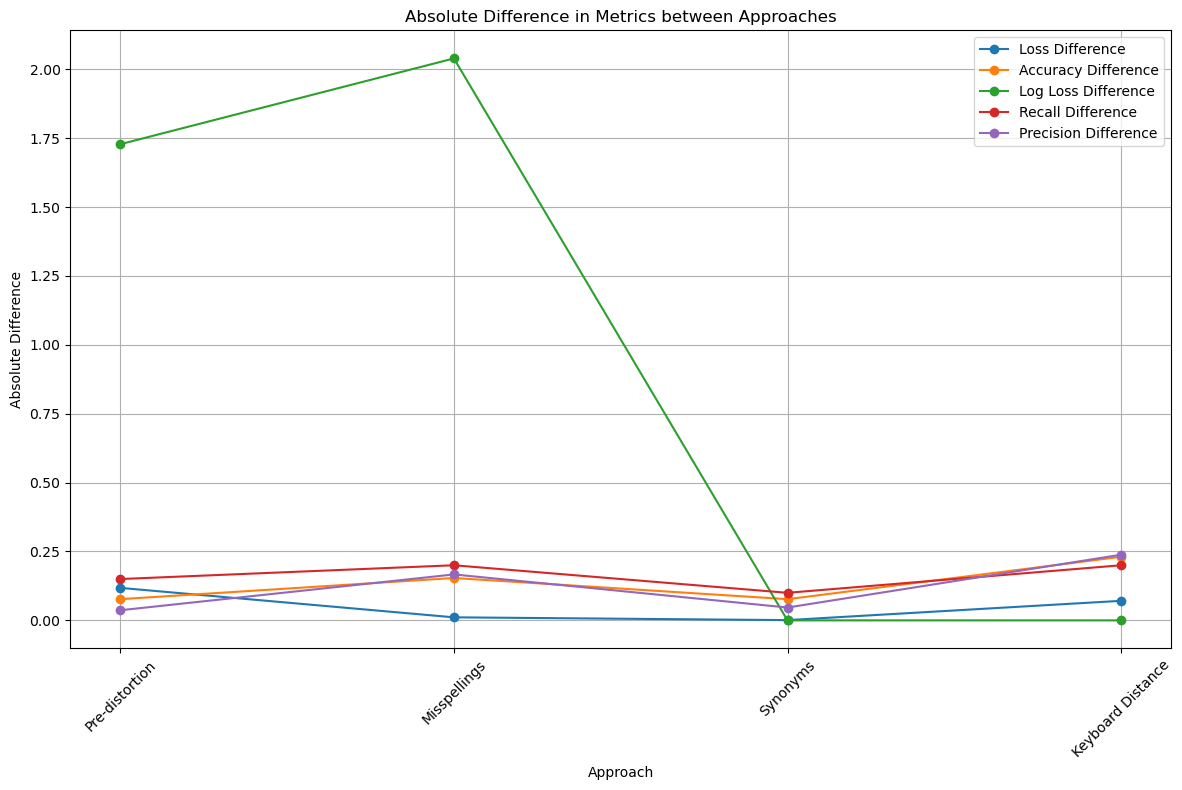

In [84]:
#Created a chart showing how much difference each approach made

import matplotlib.pyplot as plt

#defined the approaches and corresponding metric values
approach_names = ['Pre-distortion','Misspellings', 'Synonyms', 'Keyboard Distance', 'Word Splits']
loss_values = [0.5861,0.4682,0.4572, 0.4563,0.5272 ] 
accuracy_values = [0.3846,0.46154, 0.3077, 0.3846, 0.1538]  
log_loss_values = [5.3775,3.6491, 1.6094, 1.6094, 1.6094]  
recall_values = [0.45,0.6, 0.4, 0.5, 0.3] 
precision_values = [0.4133,0.45,0.2833, 0.3299, 0.09166]  

#Calculated the absolute difference in metric values between approaches
loss_difference = [abs(loss_values[i+1] - loss_values[i]) for i in range(len(loss_values)-1)]
accuracy_difference = [abs(accuracy_values[i+1] - accuracy_values[i]) for i in range(len(accuracy_values)-1)]
log_loss_difference = [abs(log_loss_values[i+1] - log_loss_values[i]) for i in range(len(log_loss_values)-1)]
recall_difference = [abs(recall_values[i+1] - recall_values[i]) for i in range(len(recall_values)-1)]
precision_difference = [abs(precision_values[i+1] - precision_values[i]) for i in range(len(precision_values)-1)]

#Plotted the absolute differences
plt.figure(figsize=(12, 8))

plt.plot(approach_names[:-1], loss_difference, marker='o', label='Loss Difference')
plt.plot(approach_names[:-1], accuracy_difference, marker='o', label='Accuracy Difference')
plt.plot(approach_names[:-1], log_loss_difference, marker='o', label='Log Loss Difference')
plt.plot(approach_names[:-1], recall_difference, marker='o', label='Recall Difference')
plt.plot(approach_names[:-1], precision_difference, marker='o', label='Precision Difference')

plt.xlabel('Approach')
plt.ylabel('Absolute Difference')
plt.title('Absolute Difference in Metrics between Approaches')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


From the graph above, we can see that the introduction of the first distortion approach(Misspelings) brought noticeable changes or differences to all the metric values. After that, the difference brought to recall, accuracy & precision decreases and slightly increases again just to come back around the same level of difference introduced by the first distortion. On the other hand, for loss and log loss, it seems that the addition of other distortion approaches have little to no effect on the model. To have a clearer picture, we'll also look at a graph depicting the actual metric values obtained by the approaches.

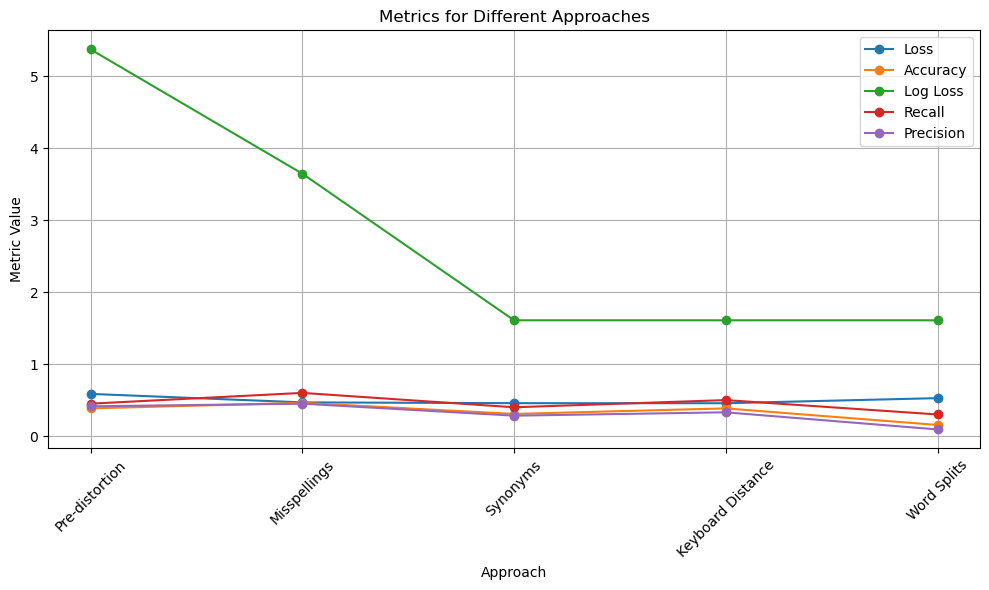

In [67]:
#Created a chart showing how much each approach changed the metrics of the model
#Plotted the metrics
plt.figure(figsize=(10, 6))

plt.plot(approach_names, loss_values, marker='o', label='Loss')
plt.plot(approach_names, accuracy_values, marker='o', label='Accuracy')
plt.plot(approach_names, log_loss_values, marker='o', label='Log Loss')
plt.plot(approach_names, recall_values, marker='o', label='Recall')
plt.plot(approach_names, precision_values, marker='o', label='Precision')

plt.xlabel('Approach')
plt.ylabel('Metric Value')
plt.title('Metrics for Different Approaches')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

To see clearly, we will create separate plots for each.

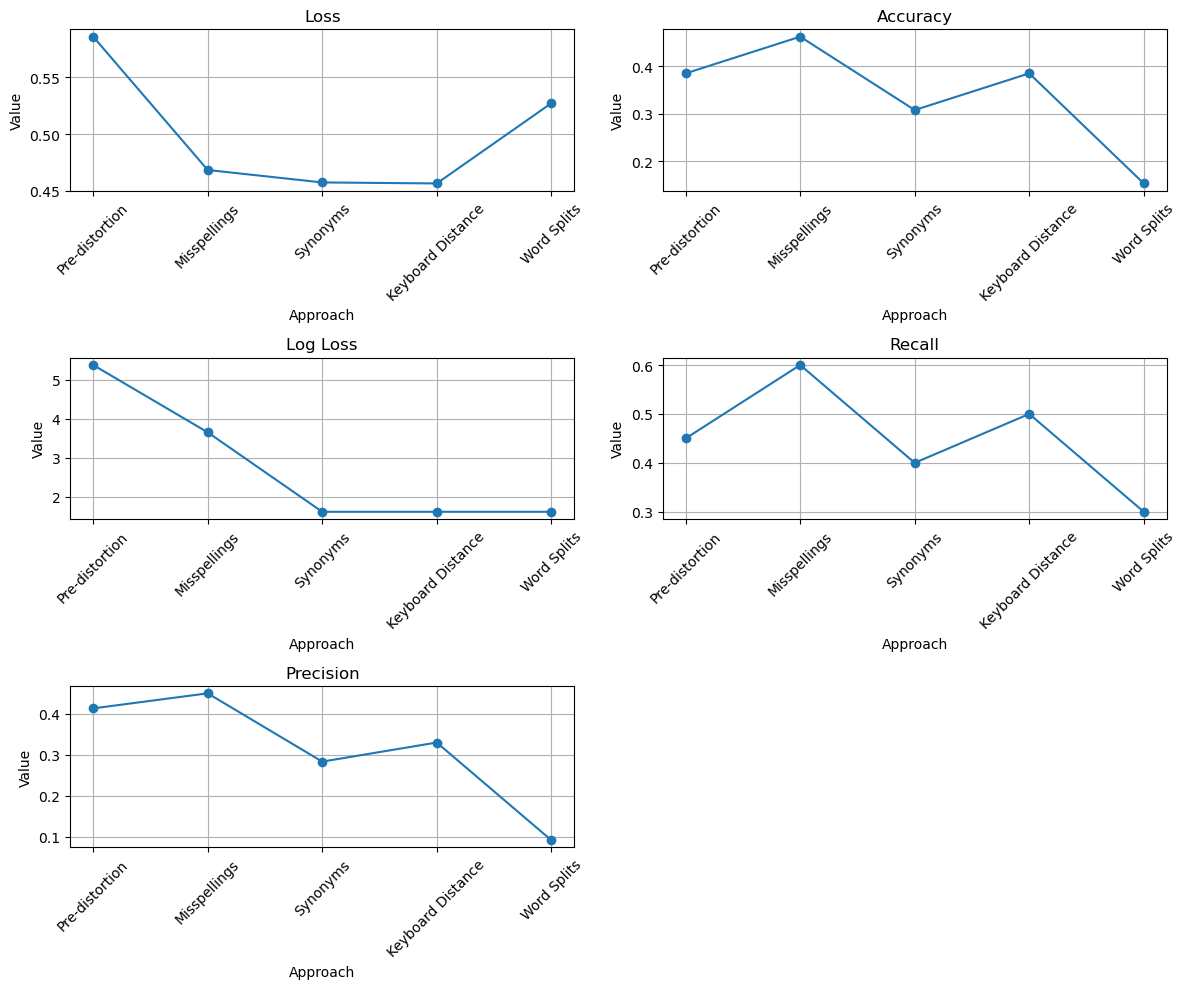

In [68]:
#Created a separate plot for each metric
metrics = {
    'Loss': loss_values,
    'Accuracy': accuracy_values,
    'Log Loss': log_loss_values,
    'Recall': recall_values,
    'Precision': precision_values
}

plt.figure(figsize=(12, 10))

for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(approach_names, values, marker='o')
    plt.title(metric)
    plt.xlabel('Approach')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

For loss, it initially significantly decreased upon the introduction of the first distortion (Misspelings). Then, the succeeding introduction of distortions only brought small increments of decrease until it greatly increased again when the 4th distortion (Word Splits) was introduced.

For log loss, it greatly decreased until the introduction of the second distrotion (Synonyms) approach. Then, the suceeding distortions brought no change at all and made the values plateau. 

For Accuracy, Recall and Precision, the introduction of the first distortion (Misspelings) approach visibly increased their respective values. Then, adding the Synonyms would make values decrease only to slightly increase again after the addition of Keyboard distance. Lastly, their values dip when the final (Word Splits) distortion approach was added. In short, the values peaked at the introduction of the first distortion.

Based on the insights taken from the graphs, it seems that the introduction of the first distortion (misspellings) had the most impact on reducing loss, and in significant improvements across the other metrics (accuracy, recall, precision); while subsequent distortions did not contribute significantly to further improvement, probably because after the first distortion, more noise were introduced which contributed to the worsening of the model performance. Given that the first distortion model had the best performance out of all distortion variations, and considering that it also outperformed the pre-distortion model (2a), which performed better than the baseline model (1h),then, we will be moving forward with the dataset containing only the pre-distorted data and the mispelled data from 2b.

##### Fine-tuned a model to match the output of the best model.

For this part, we will be using Tinybert which is a smaller model than the Mobilebert we used earlier. Firstly, we compare the sizes of the two and we verify that it is in fact, a smaller model than Mobilebert.

In [88]:
#Got the size of the model we used earlier for comparison

# Load the model
model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=5)

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total Parameters: {total_params}')

# Estimate memory size (in bytes)
memory_size = total_params * 4
print(f'Memory Size: {memory_size} bytes')

import shutil

# Save the model
model_path = 'google/mobilebert-uncased'
model.save_pretrained(model_path)

# Estimate disk space (in bytes)
disk_space = sum(os.path.getsize(os.path.join(model_path, f)) for f in os.listdir(model_path))
print(f'Disk Space: {disk_space} bytes')

# Clean up the saved model
shutil.rmtree(model_path)


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 24584453
Memory Size: 98337812 bytes
Disk Space: 98477465 bytes


In [57]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-2-v2", num_labels=5, ignore_mismatched_sizes=True)

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total Parameters: {total_params}')

# Estimate memory size (in bytes)
memory_size = total_params * 4
print(f'Memory Size: {memory_size} bytes')

import shutil
import os

# Save the model
model_path = 'cross-encoder/ms-marco-TinyBERT-L-2-v2'
model.save_pretrained(model_path)

# Estimate disk space (in bytes)
disk_space = sum(os.path.getsize(os.path.join(model_path, f)) for f in os.listdir(model_path))
print(f'Disk Space: {disk_space} bytes')

# Clean up the saved model
shutil.rmtree(model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cross-encoder/ms-marco-TinyBERT-L-2-v2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1, 128]) in the checkpoint and torch.Size([5, 128]) in the model instantiated
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 4386565
Memory Size: 17546260 bytes
Disk Space: 17551905 bytes


In [75]:
#printed the results

parameter_diff = 24584453 - 4386565
memory_diff = 98337812 - 17546260
disk_diff = 98477465 - 17551905

par_per = (parameter_diff / 24584453) * 100
rounded_par_per = round(par_per)

mem_per = (memory_diff / 98337812) * 100
rounded_mem_per = round(mem_per)

disk_per = (disk_diff / 98477465) * 100
rounded_disk_per = round(disk_per)

print(f"""
Based on the results, we can see that the new model is {parameter_diff} smaller in terms of parameter,
{memory_diff} bytes smaller in terms of memory, and {disk_diff} bytes smaller in terms of disk space. 
These connote to an {rounded_par_per}% decrease in terms of parameter size, memory size and disk size.
""")



Based on the results, we can see that the new model is 20197888 smaller in terms of parameter,
80791552 bytes smaller in terms of memory, and 80925560 bytes smaller in terms of disk space. 
These connote to an 82% decrease in terms of parameter size, memory size and disk size.



For this portion, we will tweak the fine-tuning function we used earlier in such a way that it will be using a different smaller pretrained model (Tinybert) .

In [77]:
#imported necessary packages
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler, random_split
import torch
import functools
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_score
import numpy
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def compute_metrics(p):
    preds = numpy.argmax(p.predictions, axis=1)
    corrects = numpy.argmax(p.label_ids, axis=1)
    return {"accuracy": accuracy_score(corrects, preds),
           "log_loss": log_loss(corrects, p.predictions),
            "recall": recall_score(corrects, preds, average='macro'),  # Specify average='macro'
            "precision": precision_score(corrects, preds, average='macro'),  # Specify average='macro'
            "predictions": preds,
            "correct_answers": corrects,
            "prediction logits": p.predictions
           }


class TwoColumnDFDataset(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-2-v2")

    def __getitem__(self, index):
        text = str(self.data.Text.iloc[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=50, # Statements are not longer than this
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids = inputs['input_ids'][0]
        mask = inputs['attention_mask'][0]

        #Mapped labels to integers
        label_map = {
            'Sales': 0,
            'Support': 1,
            'Complaints': 2,
            'Account_Management': 3,
            'Billing_and_Payments': 4
        }

        label = self.data.Label.iloc[index]
        label_index = label_map[label]
        labels = torch.zeros(5)  # Create a tensor of zeros with length 5
        labels[label_index] = 1  # Set the corresponding index to 1

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


    def __len__(self):
        return self.len

def train_and_evaluate_model(train_df, test_df):
    model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-2-v2",num_labels=5, ignore_mismatched_sizes=True)
    training_set = TwoColumnDFDataset(train_df)
    testing_set = TwoColumnDFDataset(test_df)
    print(f"The training data has {train_df.shape[0]} rows")
    print(f"The test data has {test_df.shape[0]} rows")
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=50,
        per_device_train_batch_size=len(training_set),
        per_device_eval_batch_size=len(testing_set),
        warmup_steps=10,
        weight_decay=0.1,
        logging_dir='./logs',
        logging_steps=10,
        #use_mps_device=False,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=training_set,
        eval_dataset=testing_set,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return {
        'model': model, 
        'evaluation': trainer.evaluate()
    }

In [78]:
#trained and evaluated on the pre-distorted data and the misspelled data using the new pretrained model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cross-encoder/ms-marco-TinyBERT-L-2-v2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1, 128]) in the checkpoint and torch.Size([5, 128]) in the model instantiated
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\1042503440.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\1042503440.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\1042503440.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,0.728400
20,0.671000
30,0.636300
40,0.616600
50,0.608000


Execution time: 104.75306725502014 seconds
Evaluation results: {'model': BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


To compare the model from 2c and the new model pretrained on Tinybert, we will display a series of bar graphs.

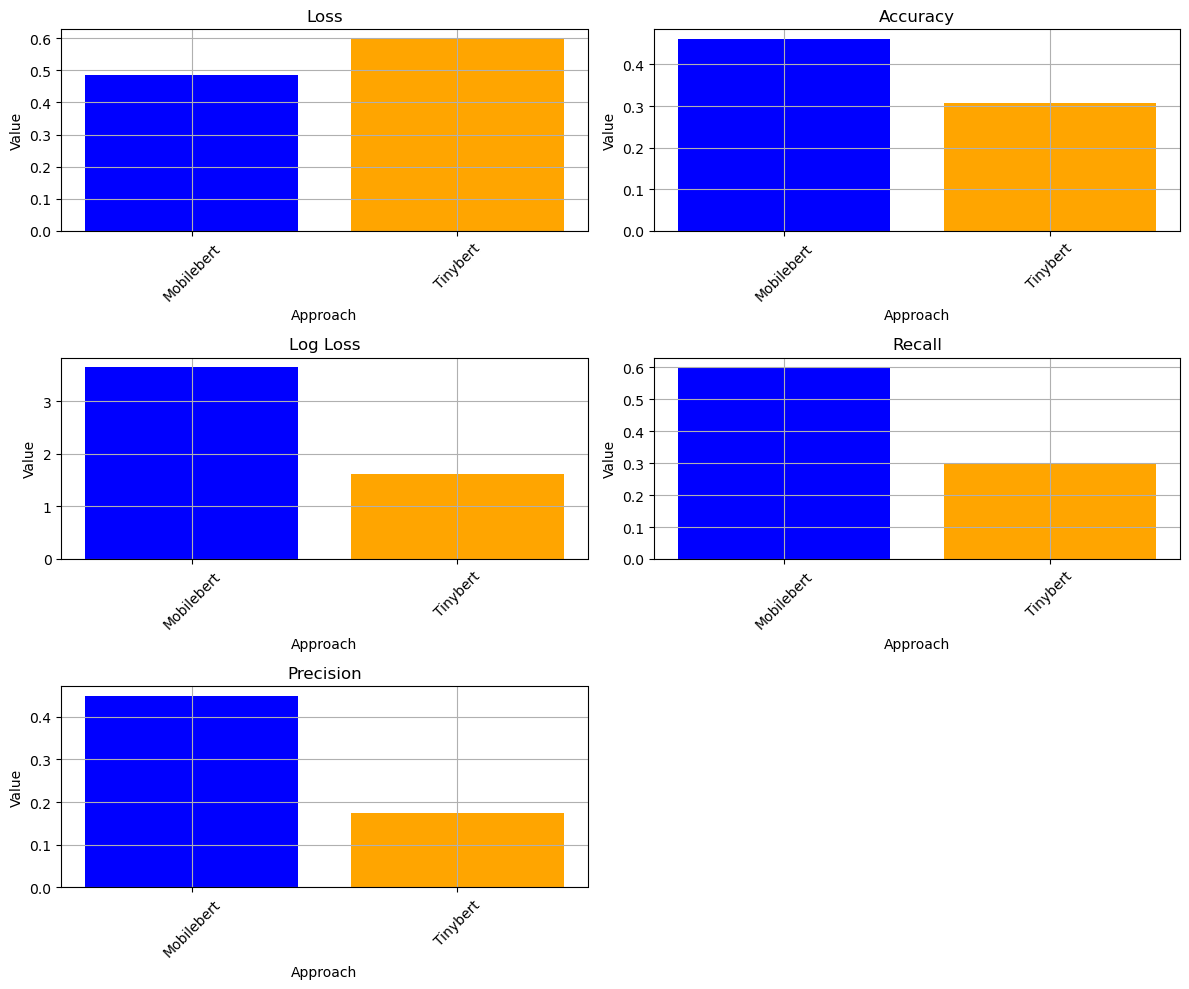

In [83]:
#improted plt
import matplotlib.pyplot as plt

#defined the approaches and corresponding metric values
approach_names = ['Mobilebert','Tinybert']
loss_values = [0.4862,0.5984] 
accuracy_values = [0.46154,0.3077]  
log_loss_values = [3.6491,1.6094]  
recall_values = [0.6,0.3] 
precision_values = [0.45,0.175]  

#Created a separate plot for each metric
metrics = {
    'Loss': loss_values,
    'Accuracy': accuracy_values,
    'Log Loss': log_loss_values,
    'Recall': recall_values,
    'Precision': precision_values
}

plt.figure(figsize=(12, 10))

for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plt.bar(approach_names, values, color=['blue', 'orange'])  # Change colors as needed
    plt.title(metric)
    plt.xlabel('Approach')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [88]:
loss_diff = abs(0.4862 - 0.5984)
acc_diff = abs(0.46154-0.3077)
log_loss_diff = abs(3.6491-1.6094)  
recall_diff = abs(0.6-0.3)
precision_diff = abs(0.45-0.175)

print(f"""
From the graphs, we can see that in terms of the performance metrics, Mobilebert still performs 
better than Tinybert, which is expected as it is 82% larger than Tinybert. Tinybert had an increased loss of
{round(loss_diff,4)}, and a decrease of {round(acc_diff,4)} in accuracy, {recall_diff} in recall, {precision_diff} in precision
and {log_loss_diff} in log loss.
""")


From the graphs, we can see that in terms of the performance metrics, Mobilebert still performs 
better than Tinybert, which is expected as it is 82% larger than Tinybert. Tinybert had an increased loss of
0.1122, and a decrease of 0.1538 in accuracy, 0.3 in recall, 0.275 in precision
and 2.0397 in log loss.



From the graphs, we can see that in terms of the performance metrics, Mobilebert still performs better than Tinybert, which is expected as it is 82% larger than Tinybert. On the other hand, in terms of inference runtime, Tinybert greatly outperforms Mobilebert. Tinybert's inference on the test set only took 0.1182 seconds while Mobilebert took 1.9165 seconds. Based on Tinybert's run, it can process 109.938 samples per second while Mobilebert can only process 6.783 samples per second. Moreover, the whole execution of training and evaluation only took 104.7531 seconds for Tinybert while Mobilebert took a very long time of 2314.49093 seconds.

##### Plot the effects of pruning the model

Given that the model from 2c (MobileBERT) outperforms the one from 3a (TinyBERT) in terms of performance metrics, but is significantly larger in size and slower in terms of training and inference runtimes, it presents an ideal candidate for pruning as the process of pruning can help reduce the model size, improve inference time, and even maintain or improve performance. Therefore, in this exercise, we will be using the model from 2c.

In [91]:
#imported necessary packages
import torch
from torch import nn, optim
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from transformers import BertForSequenceClassification
import torch.nn.functional as F
import tqdm
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler, random_split
import functools
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_score

In [90]:
#points to the correct device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # Fallback to CPU if MPS is not available

In [98]:
#tweaked the finetuning function we used earlier to use the defined full model

#imported necessary packages
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler, random_split
import torch
import functools
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_score
import numpy

def compute_metrics(p):
    preds = numpy.argmax(p.predictions, axis=1)
    corrects = numpy.argmax(p.label_ids, axis=1)
    return {"accuracy": accuracy_score(corrects, preds),
           "log_loss": log_loss(corrects, p.predictions),
            "recall": recall_score(corrects, preds, average='macro'),  # Specify average='macro'
            "precision": precision_score(corrects, preds, average='macro'),  # Specify average='macro'
            "predictions": preds,
            "correct_answers": corrects,
            "prediction logits": p.predictions
           }


class TwoColumnDFDataset(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')


    def __getitem__(self, index):
        text = str(self.data.Text.iloc[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=50, # Statements are not longer than this
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids = inputs['input_ids'][0]
        mask = inputs['attention_mask'][0]

        #Mapped labels to integers
        label_map = {
            'Sales': 0,
            'Support': 1,
            'Complaints': 2,
            'Account_Management': 3,
            'Billing_and_Payments': 4
        }

        label = self.data.Label.iloc[index]
        label_index = label_map[label]
        labels = torch.zeros(5)  # Create a tensor of zeros with length 5
        labels[label_index] = 1  # Set the corresponding index to 1

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


    def __len__(self):
        return self.len


def train_and_evaluate_model(train_df, test_df):
    model = full_model
    training_set = TwoColumnDFDataset(train_df)
    testing_set = TwoColumnDFDataset(test_df)
    print(f"The training data has {train_df.shape[0]} rows")
    print(f"The test data has {test_df.shape[0]} rows")
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=50,
        per_device_train_batch_size=len(training_set),
        per_device_eval_batch_size=len(testing_set),
        warmup_steps=10,
        weight_decay=0.1,
        logging_dir='./logs',
        logging_steps=10,
        #use_mps_device=False,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=training_set,
        eval_dataset=testing_set,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return {
        'model': model, 
        'evaluation': trainer.evaluate()
    }

In [92]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

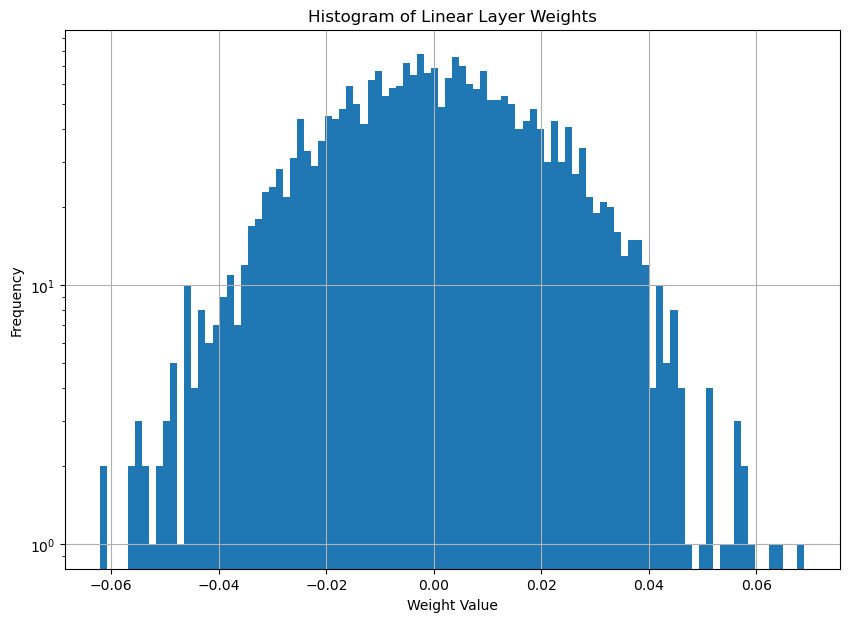

In [93]:
#displayed a historgram of the weights of the model to have a sense of its distribution

linear_layer_weights = []
for name, param in full_model.named_parameters():
    if 'classifier' in name or 'pre_classifier' in name:
        # Add the flattened weights of this linear layer to the list
        linear_layer_weights += param.data.flatten().tolist()

# Plot the histogram
plt.figure(figsize=(10, 7))
plt.hist(linear_layer_weights, bins=100)
plt.yscale('log') # Use logarithmic scale to better visualize the distribution
plt.title('Histogram of Linear Layer Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)

In [94]:
#got the size of the model prior to pruning

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


For the pruning, we will be leveraging PyTorch's prune library found in torch.nn.utils. prune.l1_unstructured shall be used to find all the smallest (by absolute value) weights and will be subsequently masked. For this exercise, we will first remove 10% of the parameters, and see how the model performs as we increase the number of removed parameters in increments of 10% until we reach 90%.

In [95]:
#imported prune
from torch.nn.utils import prune

#Defined a function to prune linear layers by n%
def prune_linear_layers(model, pruning_percent):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            #Prune pruning_percent% of the weights in the linear layers
            prune.l1_unstructured(module, name='weight', amount=pruning_percent/100)



##### 10%

In [96]:
#Applied pruning on the model with pruning_percent of 10%
prune_linear_layers(full_model,10)

In [97]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [99]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2862918.600000
20,223714.600000
30,33.983900
40,0.453400
50,0.347200


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Execution time: 1774.3484990596771 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [100]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


##### 20%

In [101]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [102]:
#got the size of the model again prior to pruning to check that we are working on the unpruned model

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


In [103]:
#Applied pruning on the model with pruning_percent of 20%
prune_linear_layers(full_model,20)

In [104]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [105]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2002328.000000
20,125907.650000
30,1.050500
40,0.464100
50,0.366300


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Execution time: 1762.0936710834503 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [106]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


##### 30%

In [107]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [108]:
#got the size of the model again prior to pruning to check that we are working on the unpruned model

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


In [109]:
#Applied pruning on the model with pruning_percent of 30%
prune_linear_layers(full_model,30)

In [110]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [111]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,1566063.200000
20,32042.068700
30,0.587200
40,0.400500
50,0.286900


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Execution time: 2137.6680855751038 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [112]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


##### 40%

In [113]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [114]:
#got the size of the model again prior to pruning to check that we are working on the unpruned model

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


In [115]:
#Applied pruning on the model with pruning_percent of 40%
prune_linear_layers(full_model,40)

In [116]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [117]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,1160764.800000
20,2213.904700
30,0.497600
40,0.362700
50,0.257200


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Execution time: 3961.841752767563 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
       

In [118]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


##### 50%

In [119]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [120]:
#got the size of the model again prior to pruning to check that we are working on the unpruned model

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


In [121]:
#Applied pruning on the model with pruning_percent of 50%
prune_linear_layers(full_model,50)

In [122]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [123]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,394883.075000
20,2.176300
30,0.415600
40,0.253700
50,0.148200


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Execution time: 7066.982641220093 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
       

In [124]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


##### 60%

In [125]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [126]:
#got the size of the model again prior to pruning to check that we are working on the unpruned model

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


In [127]:
#Applied pruning on the model with pruning_percent of 60%
prune_linear_layers(full_model,60)

In [128]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [129]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,52147.031200
20,0.546600
30,0.367300
40,0.202300
50,0.102300


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Execution time: 2804.293266773224 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
       

In [130]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


##### 70%

In [131]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [132]:
#got the size of the model again prior to pruning to check that we are working on the unpruned model

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


In [133]:
#Applied pruning on the model with pruning_percent of 70%
prune_linear_layers(full_model,70)

In [134]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [135]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,66455.825000
20,0.552800
30,0.455100
40,0.366600
50,0.269600


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Execution time: 3226.227412223816 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
       

In [136]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


##### 80%

In [137]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [138]:
#got the size of the model again prior to pruning to check that we are working on the unpruned model

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


In [139]:
#Applied pruning on the model with pruning_percent of 80%
prune_linear_layers(full_model,80)

In [140]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [141]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,16173.162500
20,0.623400
30,0.497800
40,0.482300
50,0.472400


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Execution time: 2043.5582530498505 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

In [142]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


##### 90%

In [143]:
#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [144]:
#got the size of the model again prior to pruning to check that we are working on the unpruned model

import os

model_path_before = "full_model_before_pruning.pt"
torch.save(full_model.state_dict(), model_path_before)

#Measured the file size
model_size_before = os.path.getsize(model_path_before) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model before pruning: {model_size_before} MB")


Size of the model before pruning: 94.23150157928467 MB


In [145]:
#Applied pruning on the model with pruning_percent of 90%
prune_linear_layers(full_model,90)

In [146]:
#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')

In [147]:
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,0.662800
20,0.825200
30,0.499600
40,0.495300
50,0.493500


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Execution time: 2280.310800552368 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
       

In [148]:
#Got the size of the model after pruning
model_path_after = "full_model_after_pruning.pt"
torch.save(full_model.state_dict(), model_path_after)

# Measure the file size
model_size_after = os.path.getsize(model_path_after) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Size of the model after pruning: {model_size_after} MB")


Size of the model after pruning: 94.23043632507324 MB


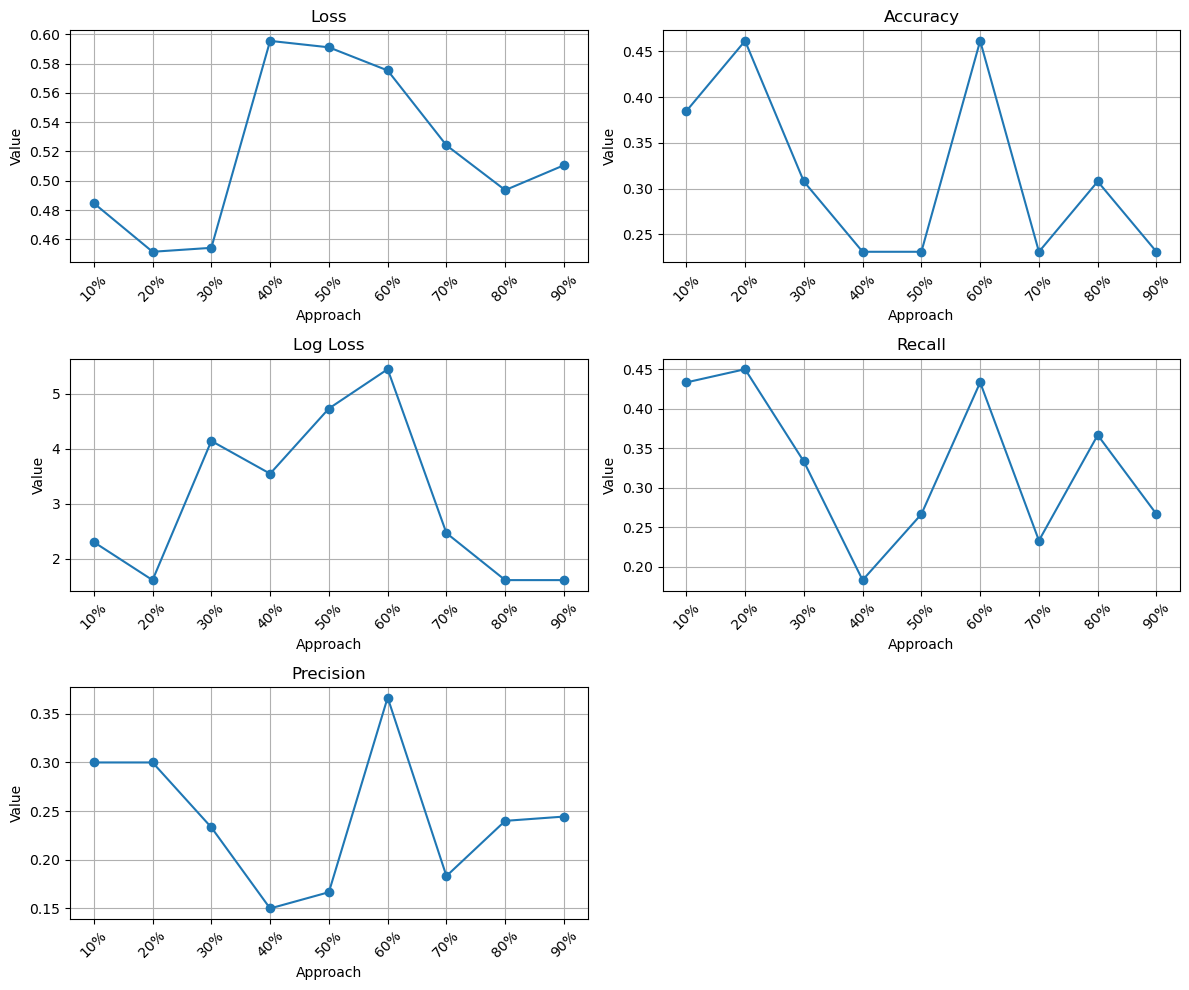

In [149]:
#Created a chart showing the effects of pruning on removing different weights %

import matplotlib.pyplot as plt

#defined the weights % and corresponding metric values
approach_names = ['10%','20%', '30%', '40%', '50%','60%','70%','80%','90%',]

loss_values = [0.4847,0.4515,0.4542,0.5955,0.5911,0.5753,0.5242, 0.4936,0.5106] 

accuracy_values = [0.3846,0.4615,0.3077,0.2308, 0.2308, 0.4615,0.2308,0.3077,0.2308]  

log_loss_values = [2.3015,1.6094,4.1401,3.5446, 4.7299, 5.4446,2.4644, 1.6094, 1.6094]  

recall_values = [0.4333,0.45,0.3333, 0.1833, 0.2667, 0.4333,0.2333,0.3667,0.2667] 

precision_values = [0.3,0.3, 0.2333,0.15, 0.1667, 0.3667,0.1833, 0.24,0.2444]  


#Created a separate plot for each metric
metrics = {
    'Loss': loss_values,
    'Accuracy': accuracy_values,
    'Log Loss': log_loss_values,
    'Recall': recall_values,
    'Precision': precision_values
}

plt.figure(figsize=(12, 10))

for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(approach_names, values, marker='o')
    plt.title(metric)
    plt.xlabel('Approach')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on the graphs above, we can see that the best performing pruned model was the 20% weights removed model. Accuracy and Recall gradually increased, and loss and log loss gradually decreased until the 20% model.Then, loss soared beyond 20%. Accuracy, Recall and Precision will increase again but not as high as the results from the 20% model, and their values will dip once again beyond the 60% model. Therefore, the best performing pruned model is the 20%weights removed model.

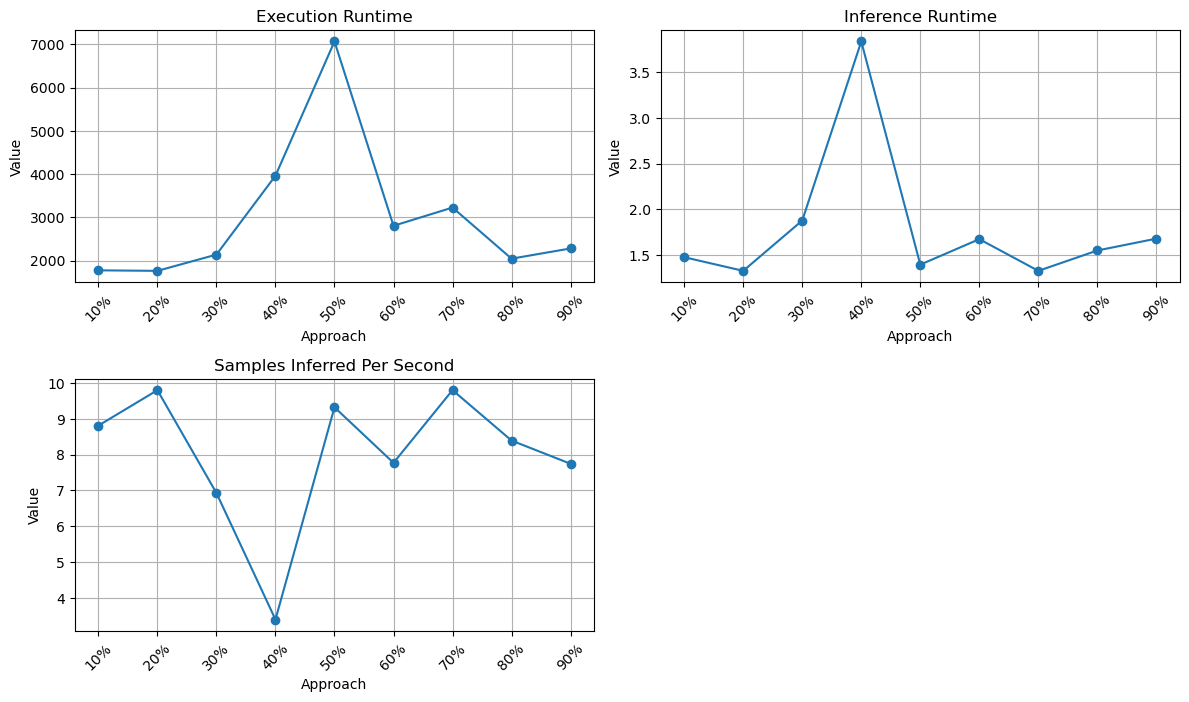

In [150]:
#Created a chart showing the effects of pruning on execution time and inference time

import matplotlib.pyplot as plt

#defined the weights % and runtimes
approach_names = ['10%','20%', '30%', '40%', '50%','60%','70%','80%','90%',]

exec_times = [1774,1762,2138,3962, 7067,2804,3226, 2044, 2280] 

eval_times = [1.4753,1.3261,1.8766, 3.836, 1.3941, 1.6729, 1.326, 1.5488, 1.6787]  

eval_samples_persec = [8.812,9.803,6.927, 3.389, 9.325, 7.771, 9.804, 8.394, 7.744]  

#Created a separate plot for each metric
metrics = {
    'Execution Runtime': exec_times,
    'Inference Runtime': eval_times,
    'Samples Inferred Per Second': eval_samples_persec,
}

plt.figure(figsize=(12, 10))

for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(approach_names, values, marker='o')
    plt.title(metric)
    plt.xlabel('Approach')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on the graph above, it is clear that the fastest pruned models are also 10% and 20%. Execution Runtime and Inference Runtime is lowest at 20%, and then these values will greatly increase beyond that, and will no longer come back to the speed at 20%. Because of these reasons and because Samples Inferred Per Second peaks at 20%, it can be claimed that the fastest pruned model is the 20% weights removed pruned model.

##### Quantized model

Before we finalize our decision on which model to quantize, we will first compare the best models. 

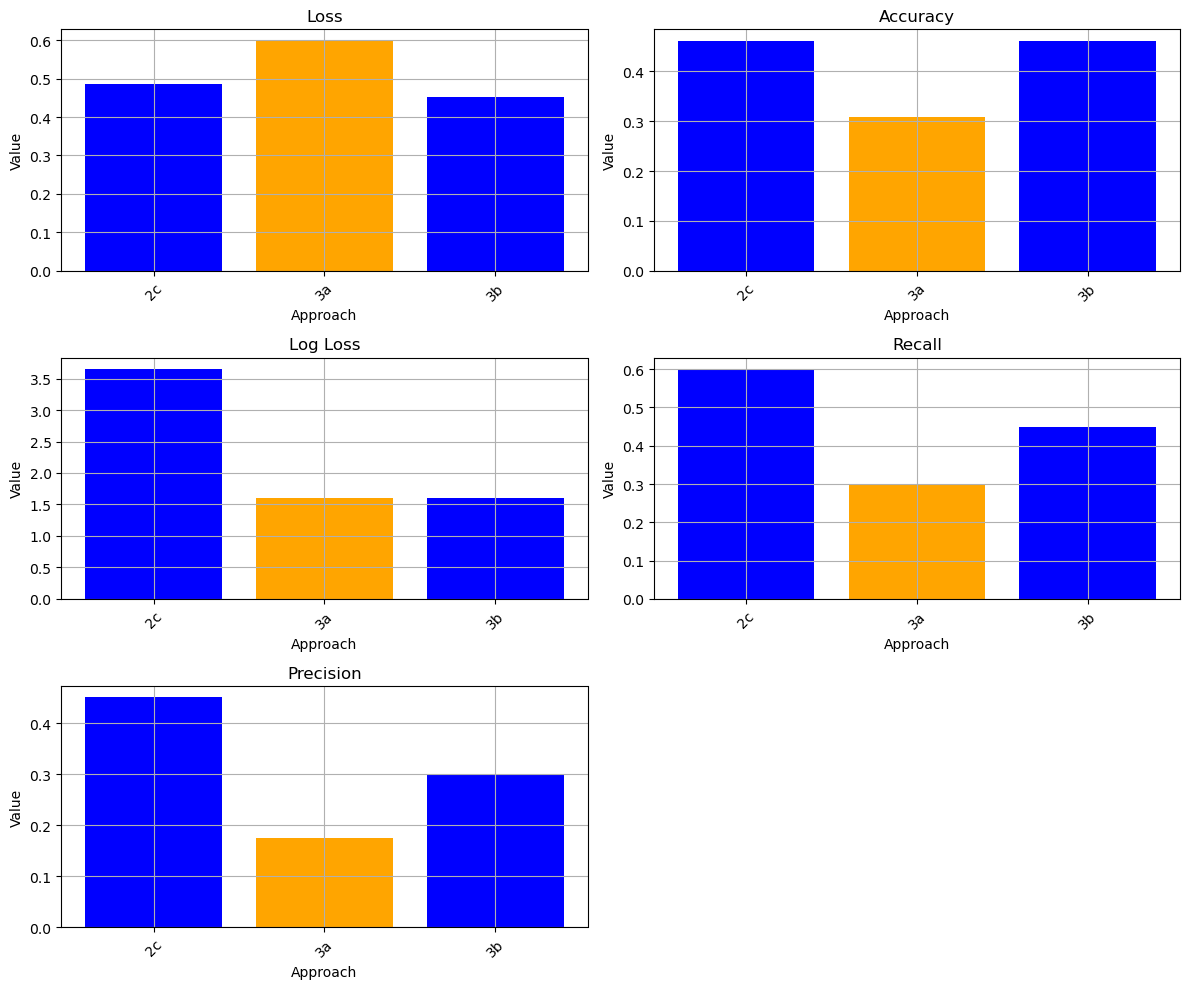

In [151]:
#improted plt
import matplotlib.pyplot as plt

#defined the approaches and corresponding metric values
approach_names = ['2c','3a', '3b']
loss_values = [0.4862,0.5984, 0.4515] 
accuracy_values = [0.46154,0.3077,0.4615]  
log_loss_values = [3.6491,1.6094,1.6094]  
recall_values = [0.6,0.3,0.45] 
precision_values = [0.45,0.175,0.3]  

#Created a separate plot for each metric
metrics = {
    'Loss': loss_values,
    'Accuracy': accuracy_values,
    'Log Loss': log_loss_values,
    'Recall': recall_values,
    'Precision': precision_values
}

plt.figure(figsize=(12, 10))

for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plt.bar(approach_names, values, color=['blue', 'orange'])  # Change colors as needed
    plt.title(metric)
    plt.xlabel('Approach')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Given that for 3b, we selected the 2c model because it outperformed the model from 3a, and we have established that it will benefit the most from pruning; then, it seems like a logical next step to continue improving the model by quantizing it; additionally,based on the graphs provided, the pruned model appears to be a smaller version of the 2c model, as it has the same accuracy but lower loss values. This suggests that pruning has effectively reduced the model's size, and made it faster(as seen in the runtime graph from 3b), without compromising its performance; therefore, in this exercise, we will be using the best model from 3b, specifically the 20% removed weights model.

In [152]:
#we now assign the best model from 2c to full_model by performing the pruning, updating the weight,
##and finetuning it on the dataset, consecutively again

#assigned the the model used from 2c to full_model variable
full_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=5)
full_model.to(device)

#Applied pruning on the model with pruning_percent of 20%
prune_linear_layers(full_model,20)

#Updated the model weights based on the pruning
for name, module in full_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Make the pruning of the 'weight' parameter permanent
        prune.remove(module, 'weight')
        
#trained and evaluated on the pre-distorted data and the misspelled data using the pruned model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\298309132.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)


Step,Training Loss
10,2002328.000000
20,125907.650000
30,1.050500
40,0.464100
50,0.366300


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Execution time: 4878.456549167633 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
       

Now we have assigned the 20% weight removed pruned model to full_model. For the next step, we will be performing quantization.

In [153]:
#imported necessary packages
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from transformers import BertForSequenceClassification
import torch.nn.functional as F
import tqdm

In [154]:
device = "cpu"

In [155]:
import os

#assigned the pruned model path to full_model_path and the quantized model to be created
full_model_path = 'full_model.pt'
quantized_model_path = 'quantized_model.pt'

#Saved the pruned model and measured its size
torch.save(full_model.state_dict(), full_model_path)
full_model_size = os.path.getsize(full_model_path) / (1024 * 1024) # Size in MB

In [157]:
#checked the size of the pruned model which will be used for comparison later on after quantizing
full_model_size #Here, we confirm that this is the pruned model because the original model size is 94.2315

94.21546173095703

In [158]:
#We now quantize the model using Pytorch's libraries
quantized_model = torch.quantization.quantize_dynamic(
    full_model, {torch.nn.Linear}, dtype=torch.qint8
)

In [159]:
#Saved and checked that quantization is successful by verifying that size was decreased by about half
torch.save(quantized_model.state_dict(), quantized_model_path)
quantized_model_size = os.path.getsize(quantized_model_path) / (1024 * 1024) # Size in MB

print(f"Original model size: {full_model_size:.2f} MB")
print(f"Quantized model size: {quantized_model_size:.2f} MB")

Original model size: 94.22 MB
Quantized model size: 36.56 MB


Now that we are done quantizing, we will now fine-tune and evaluate the model again similar to what we did to the pruned model from 3b.

In [160]:
#tweaked the finetuning function we used earlier to use the new quantized model

#imported necessary packages
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler, random_split
import torch
import functools
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_score
import numpy

def compute_metrics(p):
    preds = numpy.argmax(p.predictions, axis=1)
    corrects = numpy.argmax(p.label_ids, axis=1)
    return {"accuracy": accuracy_score(corrects, preds),
           "log_loss": log_loss(corrects, p.predictions),
            "recall": recall_score(corrects, preds, average='macro'),  # Specify average='macro'
            "precision": precision_score(corrects, preds, average='macro'),  # Specify average='macro'
            "predictions": preds,
            "correct_answers": corrects,
            "prediction logits": p.predictions
           }


class TwoColumnDFDataset(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')


    def __getitem__(self, index):
        text = str(self.data.Text.iloc[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=50, # Statements are not longer than this
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids = inputs['input_ids'][0]
        mask = inputs['attention_mask'][0]

        #Mapped labels to integers
        label_map = {
            'Sales': 0,
            'Support': 1,
            'Complaints': 2,
            'Account_Management': 3,
            'Billing_and_Payments': 4
        }

        label = self.data.Label.iloc[index]
        label_index = label_map[label]
        labels = torch.zeros(5)  # Created a tensor of zeros with length 5
        labels[label_index] = 1  # Set the corresponding index to 1

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


    def __len__(self):
        return self.len


def train_and_evaluate_model(train_df, test_df):
    model = quantized_model
    training_set = TwoColumnDFDataset(train_df)
    testing_set = TwoColumnDFDataset(test_df)
    print(f"The training data has {train_df.shape[0]} rows")
    print(f"The test data has {test_df.shape[0]} rows")
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=50,
        per_device_train_batch_size=len(training_set),
        per_device_eval_batch_size=len(testing_set),
        warmup_steps=10,
        weight_decay=0.1,
        logging_dir='./logs',
        logging_steps=10,
        #use_mps_device=False,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=training_set,
        eval_dataset=testing_set,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return {
        'model': model, 
        'evaluation': trainer.evaluate()
    }

In [161]:
#trained and evaluated on the pre-distorted data and the misspelled data using the quantized model

#added code to capture start time
import time
start_time = time.time()

#Trained and evaluated the model
evaluation_results = train_and_evaluate_model(training5_df, test_df)

#added code to capture endtime and compute for the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
#Printed evaluation results
print("Evaluation results:", evaluation_results)

The training data has 259 rows
The test data has 13 rows


C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\431884406.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(ids, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\431884406.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(mask, dtype=torch.long),
C:\Users\rodul\AppData\Local\Temp\ipykernel_27416\431884406.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)
C:\ProgramData\anaconda3\Lib\site-packages\torch\

Step,Training Loss
10,0.418400
20,0.417100
30,0.417800
40,0.417900
50,0.418100


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Execution time: 573.8129518032074 seconds
Evaluation results: {'model': MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): DynamicQuantizedLinear(in_features=384, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): DynamicQuantizedLinear(in_features=128, out_features=128, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (key): DynamicQuantizedLinear(in_features=128, out_features=128, dtype=torch.qint8, qscheme=torch.

Now we will look at how quantization affected the accuracy of the pruned model(3b).

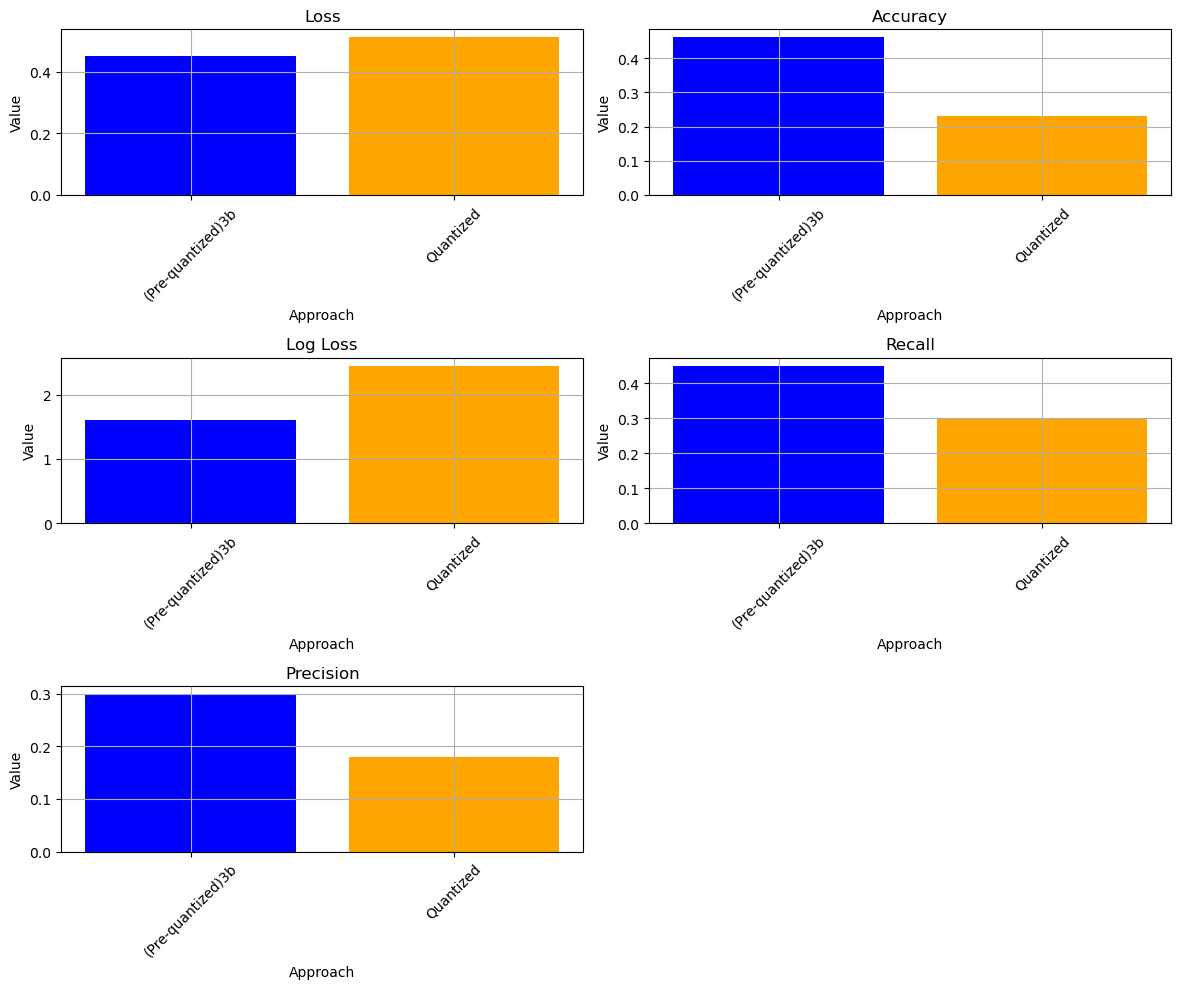

In [162]:
#improted plt
import matplotlib.pyplot as plt

#defined the approaches and corresponding metric values
approach_names = ['(Pre-quantized)3b','Quantized']
loss_values = [0.4515,0.5127] 
accuracy_values = [0.4615,0.2308]  
log_loss_values = [1.6094,2.4553]  
recall_values = [0.45,0.3] 
precision_values = [0.3,0.18]  

#Created a separate plot for each metric
metrics = {
    'Loss': loss_values,
    'Accuracy': accuracy_values,
    'Log Loss': log_loss_values,
    'Recall': recall_values,
    'Precision': precision_values
}

plt.figure(figsize=(12, 10))

for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plt.bar(approach_names, values, color=['blue', 'orange'])  # Change colors as needed
    plt.title(metric)
    plt.xlabel('Approach')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [164]:
loss_diff = abs(0.4515 - 0.5127) 
acc_diff = abs(0.4615-0.2308)
log_loss_diff = abs(1.6094-2.4553)  
recall_diff = abs(0.45-0.3)
precision_diff = abs(0.3-0.18)

print(f"""
Loss increased by: {round(loss_diff,4)}
Accuracy decreased by: {round(acc_diff,4)}
Log loss increased by: {round(log_loss_diff,4)}
Recall decreased by: {round(recall_diff,4)}
Precision decreased by: {round(precision_diff,4)}
""")


Loss increased by: 0.0612
Accuracy decreased by: 0.2307
Log loss increased by: 0.8459
Recall decreased by: 0.15
Precision decreased by: 0.12



Based on the results of the graph and the summary above, it is evident that after quantization, the model performed worse in all of the performance metrics.

Below, we will also look at the speed change introduced by quantization.

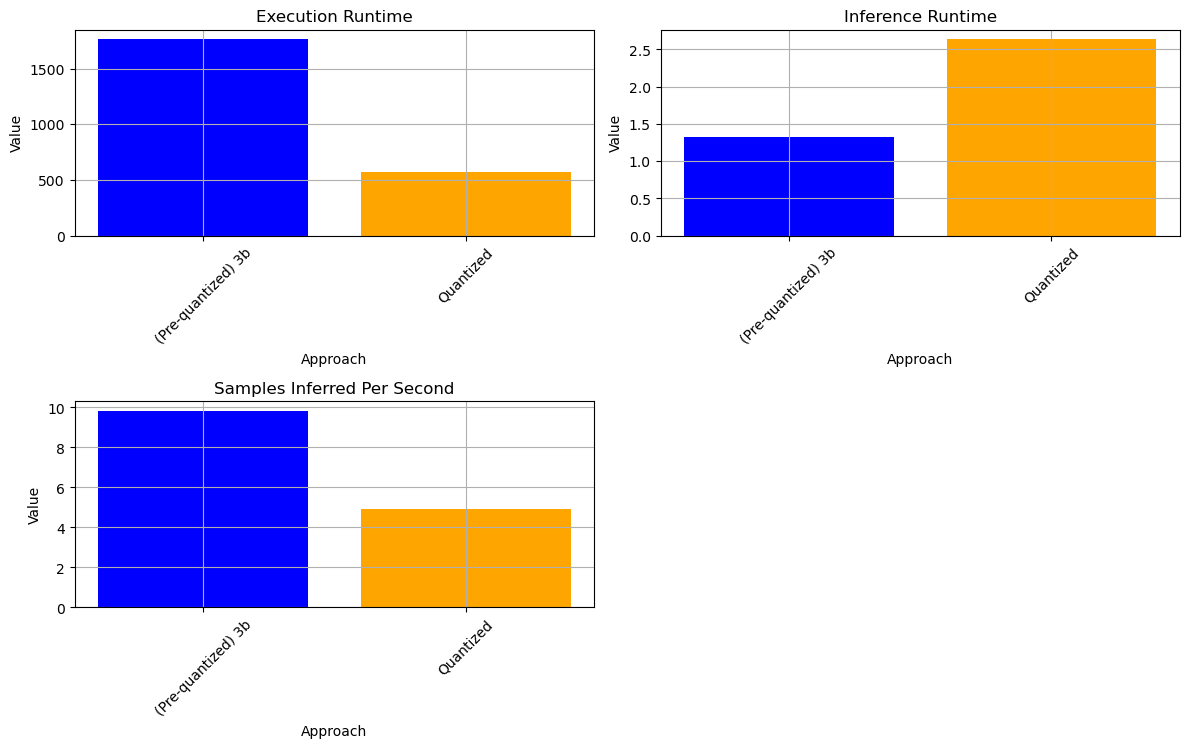

In [166]:
#Created a chart showing the effects of quantization on execution time and inference time

import matplotlib.pyplot as plt

#defined the weights % and runtimes
approach_names = ['(Pre-quantized) 3b', 'Quantized']

exec_times = [1762, 574] 

eval_times = [1.3261,2.6349]  

eval_samples_persec = [9.803, 4.934]  

#Created a separate plot for each metric
metrics = {
    'Execution Runtime': exec_times,
    'Inference Runtime': eval_times,
    'Samples Inferred Per Second': eval_samples_persec,
}

plt.figure(figsize=(12, 10))

for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plt.bar(approach_names, values, color=['blue', 'orange']) 
    plt.title(metric)
    plt.xlabel('Approach')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [167]:
exec_diff = abs(1762- 574) 
inf_diff = abs(1.3261-2.6349)
persec_diff = abs(9.803 - 4.934)  

print(f"""
Total Execution Runtime decreased by: {round(exec_diff,4)}
Inference Runtime increased by: {round(inf_diff,4)}
Samples Inferred Per Second decreased by: {round(persec_diff,4)}
""")


Total Execution Runtime decreased by: 1188
Inference Runtime increased by: 1.3088
Samples Inferred Per Second decreased by: 4.869



Based on the graph and the summary above, it can be seen that the quantized model got slower in terms of making inference on test data. However, despite these, it is also important to note that the whole execution runtime decreased by 1188 seconds, which means that in terms of training, the quantized model is so much faster than the pre-quantized model.

##### Compared against a naive technique.

For this task, we will be applying Knowledge Distillation by creating a Simple Transformer, and we will be training it against the output of full_model, which is the best performing pruned model from 3b so we can compare how it fares against the other models under similar conditions.

In [184]:
#imported necessary packages
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from transformers import BertForSequenceClassification
import torch.nn.functional as F
import tqdm

In [185]:
#made sure we are using the best device available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cpu


In [228]:
#Converted our dataframe dataset to a datasetdictionary

from datasets import Dataset, DatasetDict

#Defined a dictionary mapping original labels to numeric labels
label_mapping = {
    'Sales': 0,
    'Support': 1,
    'Complaints': 2,
    'Account_Management': 3,
    'Billing_and_Payments': 4
}

#Mapped the labels using the dictionary
copy_train = training5_df.copy()
copy_train['Label'] = copy_train['Label'].map(label_mapping)

copy_test = test_df.copy()
copy_test['Label'] = copy_test['Label'].map(label_mapping)


#Reset the index of the Train DataFrame
training5_df_reset_index = copy_train.copy().reset_index(drop=True)

#Created a Dataset from the DataFrame
train_dataset = Dataset.from_pandas(training5_df_reset_index)

#Reset the index of the Test DataFrame
test_df_reset_index = copy_test.copy().reset_index(drop=True)

#Created a Dataset from the DataFrame
test_dataset = Dataset.from_pandas(test_df_reset_index)

#Organized the datasets into a DatasetDict
dataset_dict = DatasetDict({"train": train_dataset, "test": test_dataset})

#Printed the dataset
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['Text', 'Label'],
        num_rows: 259
    })
    test: Dataset({
        features: ['Label', 'Text'],
        num_rows: 13
    })
})


In [222]:
#set tokenizer to the same tokenizer we used for our Mobilebert model
tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

In [223]:
#defined a function that when called tokenizes the dataset
def encode(examples):
    return tokenizer(examples['Text'], padding='max_length', truncation=True, max_length=128)

In [229]:
#called the function above on the dataset
encoded_dataset = dataset_dict.map(encode, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Label'])
#Dropped the 'token_type_ids' column from the encoded dataset
encoded_dataset = encoded_dataset.remove_columns('token_type_ids')


Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

In [230]:
#checked mapping was successful
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['Text', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 259
    })
    test: Dataset({
        features: ['Label', 'Text', 'input_ids', 'attention_mask'],
        num_rows: 13
    })
})

In [212]:
#Now we assign our full model as the teacher model
teacher_model = full_model
teacher_model

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [213]:
teacher_model.to(device)

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [215]:
#defined a predict function that takes a pytorch model as an argument, input_ids and an 
#optional attention_mask and outputs the logits of the different classes
def model_predict(model, input_ids, attention_mask=None):
    model.eval()  #set the model only to eval mode so that it will only make inferences
    with torch.no_grad():
        if attention_mask is not None:
            logits = model(input_ids, attention_mask=attention_mask)
        else:
            logits = model(input_ids)
    return logits

In [216]:
#defined a function that calculates accuracy
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)  
    corrects = (preds == labels).float()  
    accuracy = corrects.sum() / len(corrects)
    return accuracy.item()

In [218]:
#defined a function that calculates log loss

from sklearn.metrics import log_loss

def calculate_log_loss(logits, labels):
    probabilities = F.softmax(logits, dim=1)
    return log_loss(labels.cpu().numpy(), probabilities.cpu().numpy())


In [219]:
#defined a function that calculates recall
from sklearn.metrics import recall_score

def calculate_recall(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return recall_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')


In [220]:
#defined a function that calculates precision
from sklearn.metrics import precision_score

def calculate_precision(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return precision_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')


In [231]:
#Used DataLoader for the datasets
train_loader = DataLoader(encoded_dataset['train'].shuffle(), batch_size=16)
test_loader = DataLoader(encoded_dataset['test'].shuffle(), batch_size=1000)#set batch size to 1000 so it will get all data


In [232]:
#checked dataset is in compatible format
test_batch = list(test_loader)[0] #we list it so it can be subscriptable
test_batch

{'Label': tensor([4, 2, 3, 0, 2, 3, 2, 1, 0, 4, 1, 3, 3]),
 'input_ids': tensor([[ 101, 1045, 1005,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0],
         [ 101, 1000, 1045,  ...,    0,    0,    0],
         ...,
         [ 101, 1000, 1045,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [233]:
#sent to device
test_batch = {k: v.to(device) for k, v in test_batch.items()}
test_batch 

{'Label': tensor([4, 2, 3, 0, 2, 3, 2, 1, 0, 4, 1, 3, 3]),
 'input_ids': tensor([[ 101, 1045, 1005,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0],
         [ 101, 1000, 1045,  ...,    0,    0,    0],
         ...,
         [ 101, 1000, 1045,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [235]:
test_input_ids = test_batch['input_ids']
test_input_ids

tensor([[ 101, 1045, 1005,  ...,    0,    0,    0],
        [ 101, 1045, 1005,  ...,    0,    0,    0],
        [ 101, 1000, 1045,  ...,    0,    0,    0],
        ...,
        [ 101, 1000, 1045,  ...,    0,    0,    0],
        [ 101, 1045, 1005,  ...,    0,    0,    0],
        [ 101, 1045, 1005,  ...,    0,    0,    0]])

In [237]:
#tested that our teacher model has the same accuracy as our full_model, meaning it is the same model
teacher_test_output = model_predict(teacher_model, test_input_ids, test_batch['attention_mask'])
calculate_accuracy(teacher_test_output.logits, test_batch['Label'])

0.4615384638309479

Now, we will begin creating our student model using a SimpleTransformer

In [238]:
#Created Simple Transformer class
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleTransformer, self).__init__()
        #Calling super(SimpleTransformer, self).__init__() initializes the superclass (likely nn.
        #Module) to make sure that the SimpleTransformer class inherits all the properties and methods
        #of its superclass.
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.encoder = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8)
        self.pooler = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.encoder(x)
        x = torch.mean(x, dim=1)
        x = torch.tanh(self.pooler(x))
        logits = self.classifier(x)
        return logits

input_dim = tokenizer.vocab_size
hidden_dim = 128  # Smaller than BERT's hidden size
output_dim = 5 #because we have 5 labels  
student_model = SimpleTransformer(input_dim, hidden_dim, output_dim) #created our SimpleTransformer model

In [239]:
#created an optimizer for the student model's training
optimizer = AdamW(student_model.parameters(), lr=5e-5)

C:\Users\rodul\AppData\Roaming\Python\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [240]:
#defined loss function for the Knowledge distillation
loss_fn_kl = nn.KLDivLoss(reduction='batchmean')

In [241]:
#set same set of parameters as our previous models
num_epochs = 50
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=10, num_training_steps=num_training_steps)

In [242]:
student_model.to(device)

SimpleTransformer(
  (embedding): Embedding(30522, 128)
  (encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (pooler): Linear(in_features=128, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)

In [243]:
teacher_model.eval()  #Ensured the teacher model is only in eval mode

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

Now that everthing has been set up, we can now commence training.

In [244]:
#trained the student model against the output of the teacher model which is our best 3b classifier
for epoch in range(num_epochs):
    for batch in tqdm.tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        input_ids = batch['input_ids']
        
        with torch.no_grad():#disabled gradient calculation
            teacher_logits = teacher_model(input_ids, attention_mask=batch['attention_mask']).logits #makes teacher model make predictions
            teacher_probs = F.softmax(teacher_logits, dim=-1)
         
        student_logits = student_model(input_ids)
        student_log_probs = F.log_softmax(student_logits, dim=-1)
        loss = loss_fn_kl(student_log_probs, teacher_probs)

        optimizer.zero_grad() #cleared the gradients of all optimized tensors to avoid gradients accumulation from multiple backward passes
        loss.backward() #computes the gradients of the loss
        optimizer.step() #updates the model parameters based on the computed gradients.
        lr_scheduler.step() #called at the end of each training iteration or epoch to update the learning rate according to a predefined schedule

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

100%|██████████| 17/17 [00:40<00:00,  2.39s/it]


Epoch: 0, Loss: 0.5062322616577148


100%|██████████| 17/17 [00:38<00:00,  2.26s/it]


Epoch: 1, Loss: 0.4714323580265045


100%|██████████| 17/17 [00:40<00:00,  2.40s/it]


Epoch: 2, Loss: 0.4733802378177643


100%|██████████| 17/17 [00:40<00:00,  2.39s/it]


Epoch: 3, Loss: 0.4749927520751953


100%|██████████| 17/17 [00:41<00:00,  2.47s/it]


Epoch: 4, Loss: 0.4696009159088135


100%|██████████| 17/17 [00:36<00:00,  2.12s/it]


Epoch: 5, Loss: 0.4686817228794098


100%|██████████| 17/17 [00:33<00:00,  2.00s/it]


Epoch: 6, Loss: 0.46830955147743225


100%|██████████| 17/17 [00:34<00:00,  2.02s/it]


Epoch: 7, Loss: 0.46620020270347595


100%|██████████| 17/17 [00:40<00:00,  2.36s/it]


Epoch: 8, Loss: 0.465082049369812


100%|██████████| 17/17 [00:42<00:00,  2.51s/it]


Epoch: 9, Loss: 0.4650976359844208


100%|██████████| 17/17 [00:42<00:00,  2.51s/it]


Epoch: 10, Loss: 0.46250882744789124


100%|██████████| 17/17 [00:44<00:00,  2.60s/it]


Epoch: 11, Loss: 0.4612767696380615


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Epoch: 12, Loss: 0.46103572845458984


100%|██████████| 17/17 [00:37<00:00,  2.21s/it]


Epoch: 13, Loss: 0.4597746431827545


100%|██████████| 17/17 [00:39<00:00,  2.32s/it]


Epoch: 14, Loss: 0.45773276686668396


100%|██████████| 17/17 [00:38<00:00,  2.26s/it]


Epoch: 15, Loss: 0.4599258601665497


100%|██████████| 17/17 [00:39<00:00,  2.34s/it]


Epoch: 16, Loss: 0.4576093852519989


100%|██████████| 17/17 [00:38<00:00,  2.29s/it]


Epoch: 17, Loss: 0.45555830001831055


100%|██████████| 17/17 [00:38<00:00,  2.27s/it]


Epoch: 18, Loss: 0.4511723518371582


100%|██████████| 17/17 [00:37<00:00,  2.22s/it]


Epoch: 19, Loss: 0.45142480731010437


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Epoch: 20, Loss: 0.4495229721069336


100%|██████████| 17/17 [00:34<00:00,  2.05s/it]


Epoch: 21, Loss: 0.4503788650035858


100%|██████████| 17/17 [00:32<00:00,  1.94s/it]


Epoch: 22, Loss: 0.44785988330841064


100%|██████████| 17/17 [00:33<00:00,  1.94s/it]


Epoch: 23, Loss: 0.4483979046344757


100%|██████████| 17/17 [00:33<00:00,  1.98s/it]


Epoch: 24, Loss: 0.44769200682640076


100%|██████████| 17/17 [00:34<00:00,  2.00s/it]


Epoch: 25, Loss: 0.4474201202392578


100%|██████████| 17/17 [00:33<00:00,  1.99s/it]


Epoch: 26, Loss: 0.4457579553127289


100%|██████████| 17/17 [00:34<00:00,  2.02s/it]


Epoch: 27, Loss: 0.4445829391479492


100%|██████████| 17/17 [00:35<00:00,  2.10s/it]


Epoch: 28, Loss: 0.443566232919693


100%|██████████| 17/17 [00:49<00:00,  2.90s/it]


Epoch: 29, Loss: 0.44124162197113037


100%|██████████| 17/17 [00:46<00:00,  2.74s/it]


Epoch: 30, Loss: 0.4407902956008911


100%|██████████| 17/17 [00:43<00:00,  2.55s/it]


Epoch: 31, Loss: 0.43830180168151855


100%|██████████| 17/17 [00:42<00:00,  2.47s/it]


Epoch: 32, Loss: 0.440348744392395


100%|██████████| 17/17 [00:42<00:00,  2.53s/it]


Epoch: 33, Loss: 0.4375903308391571


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch: 34, Loss: 0.4380253851413727


100%|██████████| 17/17 [01:00<00:00,  3.57s/it]


Epoch: 35, Loss: 0.4362461566925049


100%|██████████| 17/17 [00:49<00:00,  2.93s/it]


Epoch: 36, Loss: 0.4363255500793457


100%|██████████| 17/17 [00:46<00:00,  2.72s/it]


Epoch: 37, Loss: 0.43294379115104675


100%|██████████| 17/17 [00:45<00:00,  2.70s/it]


Epoch: 38, Loss: 0.43341028690338135


100%|██████████| 17/17 [00:46<00:00,  2.74s/it]


Epoch: 39, Loss: 0.4327554702758789


100%|██████████| 17/17 [01:09<00:00,  4.10s/it]


Epoch: 40, Loss: 0.43152472376823425


100%|██████████| 17/17 [01:03<00:00,  3.76s/it]


Epoch: 41, Loss: 0.43135595321655273


100%|██████████| 17/17 [00:56<00:00,  3.29s/it]


Epoch: 42, Loss: 0.431619256734848


100%|██████████| 17/17 [01:10<00:00,  4.17s/it]


Epoch: 43, Loss: 0.4293487071990967


100%|██████████| 17/17 [01:13<00:00,  4.34s/it]


Epoch: 44, Loss: 0.42899730801582336


100%|██████████| 17/17 [01:08<00:00,  4.03s/it]


Epoch: 45, Loss: 0.43313977122306824


100%|██████████| 17/17 [01:10<00:00,  4.17s/it]


Epoch: 46, Loss: 0.42954280972480774


100%|██████████| 17/17 [01:09<00:00,  4.07s/it]


Epoch: 47, Loss: 0.42606210708618164


100%|██████████| 17/17 [00:57<00:00,  3.35s/it]


Epoch: 48, Loss: 0.42976322770118713


100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

Epoch: 49, Loss: 0.4316349923610687


Now we look at how our simple model performs on the test set using our metrics.

In [245]:
#used the model to make predictions
student_model_output = model_predict(student_model, test_input_ids)

In [247]:
#calculated accuracy
calculate_accuracy(student_model_output, test_batch['Label'])

0.1538461595773697

In [249]:
#calculated log loss
calculate_log_loss(student_model_output, test_batch['Label'])

1.6124560750265302

In [250]:
#calculated recall
calculate_recall(student_model_output, test_batch['Label'])

0.16666666666666666

In [251]:
#calculated precision
calculate_precision(student_model_output, test_batch['Label'])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.075

Our best performing model in terms of the metrics is the model from 2c(pre-pruned & pre-quantized); but since our best model from 3b is performing almost as good as the one from 2c, then we will be comparing the results of the student model against these two.

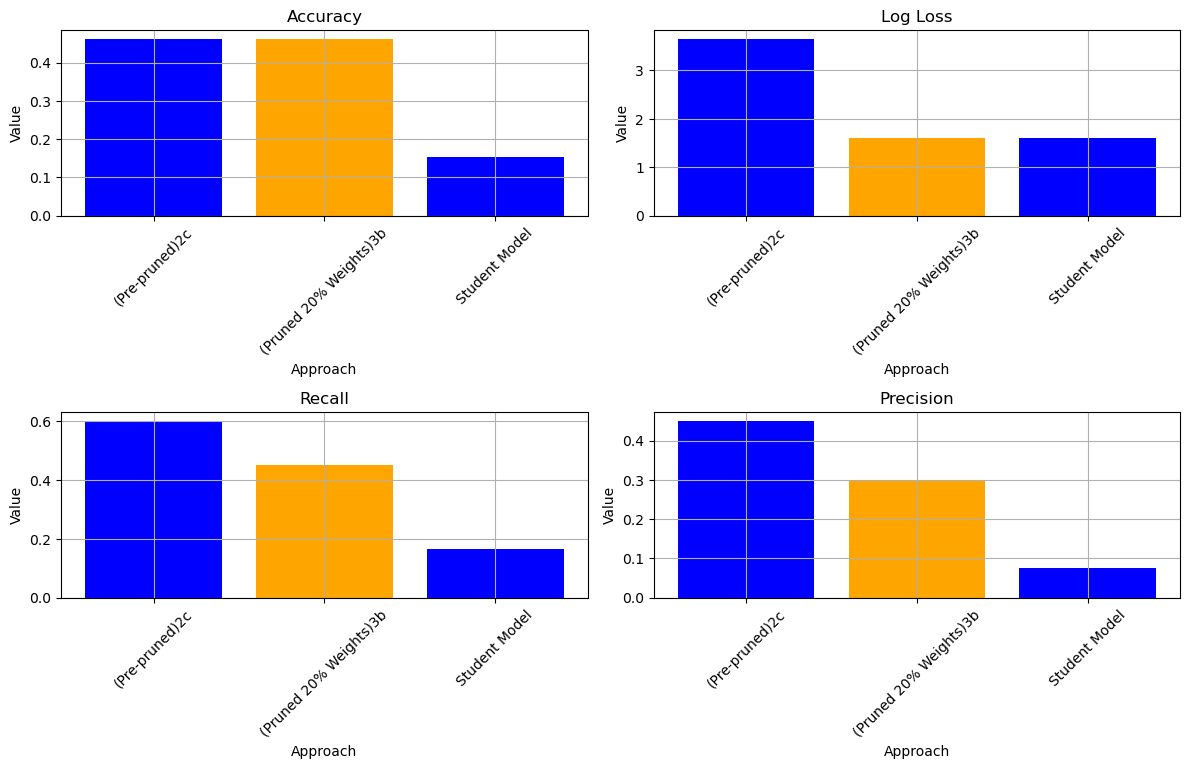

In [264]:
#improted plt
import matplotlib.pyplot as plt

#defined the approaches and corresponding metric values
approach_names = ['(Pre-pruned)2c','(Pruned 20% Weights)3b','Student Model']
accuracy_values = [0.46154,0.4615,0.1538]  
log_loss_values = [3.6491, 1.6094,1.6125]  
recall_values = [0.6,0.45,0.1667] 
precision_values = [0.45,0.3,0.075]  

#Created a separate plot for each metric
metrics = {
    'Accuracy': accuracy_values,
    'Log Loss': log_loss_values,
    'Recall': recall_values,
    'Precision': precision_values
}

plt.figure(figsize=(12, 10))

for i, (metric, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plt.bar(approach_names, values, color=['blue', 'orange'])  # Change colors as needed
    plt.title(metric)
    plt.xlabel('Approach')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on the performance metrics, it can be seen that the Student Model is outperformed by the two other models in all aspects.

Based on performance metrics, the best performing model is still the model from 2c which is from a pre-trained MobileBert model fine-tuned on a dataset that consisted of the original data expanded by round-trip translations and a misspelling distortion. However, the pruned version of this model (3b 20% weights removed) is almost as good, and has a much faster inference runtime and less size; hence, I am recommending the Pruned 3b 20% weights removed model for the company's mobile app because it has a better balance between performance and efficiency. Since the model on the mobile app will mostly be used for inference to identify intents, then a faster inference time without sacrificing much of the model's accuracy is the optimal choice.

However, should the company decide to put more importance in training, then, ideally, a more accurate version of the quantized model from 3c will be the best option. Despite its slower inference time compared to the pre-pruned and pre-quantized models, the significant reduction in training runtime greatly reduces the overall execution runtime of the model. Moreover, since the model is in smaller size, it will contribute to faster downloads and less storage requirement on the user's device, which are important factors for mobile apps.